In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 26,
                    'figure.max_open_warning': 200})
import numpy as np
import pandas as pd
import urllib.request

from date_utils import readable_date, get_date_format

In [2]:
# Load Data.
# Thanks to the Covid Tracking Project for collecting excellent data.
url = 'http://covidtracking.com/api/states/daily.csv'
urllib.request.urlretrieve(url, 'Data/states-daily.csv')
df = pd.read_csv("Data/states-daily.csv", sep=',', header=0)
df_vals = df.values

abbrevs_df = pd.read_csv("Data/state_abbreviations.csv", sep=',', header=0)
state_abbrevs = {
    state : abbrev for [state, abbrev] in abbrevs_df.values
}
census_df = pd.read_csv("Data/state_populations.csv", sep=',', header=0)
# Population data from:
# Table 1. Annual Estimates of the Resident Population for the United States, Regions, States, and Puerto Rico: April 1, 2010 to July 1, 2019 (NST-EST2019-01)
state_pops = {
    state_abbrevs[state].replace(' ', '_'): int(pop.replace(',', '')) for [state, pop] in census_df.values
}

In [3]:
# Helper functions to read the dataframe.
def get_idx(state, date):
    i = np.where(df_vals[:, df.columns.tolist().index('state')] == state)[0]
    j = np.where(df_vals[:, df.columns.tolist().index('date')] == date)[0]
    return set(i).intersection(set(j)).pop()
    
def get_val(state, date, col_name):
    idx = get_idx(state, date)
    return df[[col_name]].values[idx]

def get_positive(state, date):
    return get_val(state, date, 'positive')

def get_negative(state, date):
    return get_val(state, date, 'negative')

def get_total(state, date):
    return get_val(state, date, 'total')

In [4]:
# The main part of the model to estimate total number of infections.
def calc_sum_z(N, num_pos, num_neg, c):
    try:
        return (N*num_pos) / (c*num_neg + num_pos)
    except:
        return (N*num_pos) / (c(N, num_pos, num_neg)*num_neg + num_pos)

def get_latent_total(state, date, c):
    return calc_sum_z(state_pops[state], get_positive(state, date), get_negative(state, date), c)

In [5]:
# Dates to plot in the graph
dates = [get_date_format(d, 3, 2020) for d in range(16, 32)] # march dates (before the 16th many did not report negative test counts)
dates.extend([get_date_format(d, 4, 2020) for d in range(1, 27)]) # april dates
readable_dates = list(map(readable_date, dates))
n_dates = len(dates)
print(readable_dates)

['3/16', '3/17', '3/18', '3/19', '3/20', '3/21', '3/22', '3/23', '3/24', '3/25', '3/26', '3/27', '3/28', '3/29', '3/30', '3/31', '4/1', '4/2', '4/3', '4/4', '4/5', '4/6', '4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16', '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26']


In [6]:
# Shared plotting helpers.
markers = ['.', '+', '*', '^']

def finalize_plot(dates, y_label, fname):
    plt.xlim([0, len(dates)-1])
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs], fontsize=20)
    plt.xlabel("Date", fontsize=34)
    plt.ylabel(y_label, fontsize=34)
    plt.yticks(fontsize=20)
    lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
    plt.savefig(fname, dpi=300, bbox_inches='tight', bbox_artists=[lgd])
    #plt.close()
    
def plot_pos_neg_pop(state, dates):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', color='black', marker='+')
    plt.semilogy(positives, label='Positive Tests', color='red', marker='+')
    plt.semilogy(negatives, label='Negative Tests', color='green', marker='+')
    
def logistic(x_min, x_max, y_min, y_max, j, slope):
    x_range = x_max - x_min
    x_mid = (x_max + x_min) / 2
    return y_min + (y_max-y_min)*(1 / (1 + np.exp(-slope*(j - x_mid)/x_range)))

def linear(x_min, x_max, y_min, y_max, j):
    x_range = x_max - x_min
    return y_min + j*(y_max - y_min)/x_range

In [7]:
# Calc c based on serological studies
def calc_c(state, date, Z):
    pop = state_pops[state]
    pos = get_positive(state, date)
    neg = get_negative(state, date)
    return ((pop*pos) / (Z*neg) - (pos / neg))[0]

# Stanford study
c_stanford_lower  = calc_c("CA", dates[readable_dates.index("4/4")], 0.00094*state_pops["CA"])
c_stanford_mean   = calc_c("CA", dates[readable_dates.index("4/4")], 0.0089*state_pops["CA"])
c_stanford_upper  = calc_c("CA", dates[readable_dates.index("4/4")], 0.02*state_pops["CA"])
print(c_stanford_lower, c_stanford_mean, c_stanford_upper)

# NYC Study
c_nyc_mean = calc_c("NY", dates[readable_dates.index("4/21")], 0.139*state_pops["NY"]) 
#c_nyc_upper = calc_c("NY", dates[readable_dates.index("4/21")], 0.21*state_pops["NY"])
print(c_nyc_mean) #c_nyc_lower, c_nyc_upper)

"""
# Miami study
c_flo = calc_c("FL", dates[readable_dates.index("4/23")], 0.06*state_pops["FL"])
print(c_flo)
"""

# Stanford - Manual
pop_sc = 1928000
pos_sc = 1148
neg_sc = 10912
stanford_min = 0.00094*pop_sc
stanford_max = 0.0167*pop_sc
stanford_mean = 0.0081*pop_sc
c_stanford_min = (pop_sc*pos_sc)/(stanford_min*neg_sc) - (pos_sc / neg_sc)
print(c_stanford_min)
c_stanford_max = (pop_sc*pos_sc)/(stanford_max*neg_sc) - (pos_sc / neg_sc)
print(c_stanford_max)
print((pop_sc*pos_sc)/(stanford_mean*neg_sc) - (pos_sc / neg_sc))

stanford_min_bd = 0.018*pop_sc
stanford_max_bd = 0.057*pop_sc
#stanford_mean = 0.0081*pop_sc
print((pop_sc*pos_sc)/(stanford_min_bd*neg_sc) - (pos_sc / neg_sc))
print((pop_sc*pos_sc)/(stanford_max_bd*neg_sc) - (pos_sc / neg_sc))
#print((pop_sc*pos_sc)/(stanford_mean*neg_sc) - (pos_sc / neg_sc))

stanford_min = stanford_min / pop_sc
stanford_max = stanford_max / pop_sc

125.71149970765974 13.171606851861634 5.795719653008637
3.9207550252377965
111.81530386223248
6.194512002388185
12.883100720466311
5.739532420984034
1.7405013633791222


In [8]:
print(stanford_min)
print(stanford_max)

0.00094
0.0167


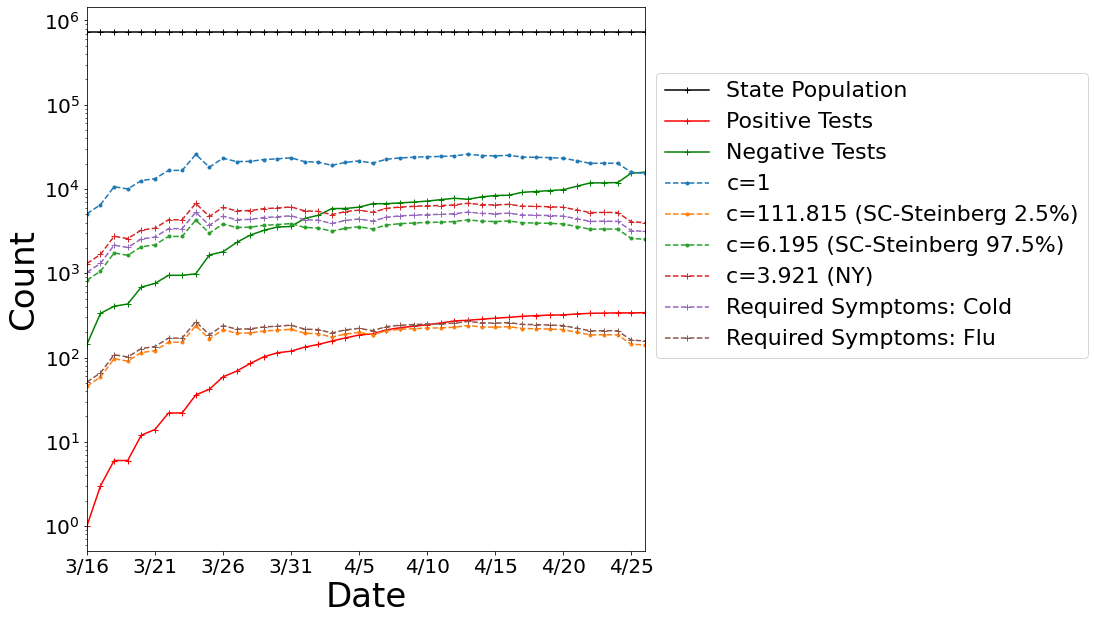

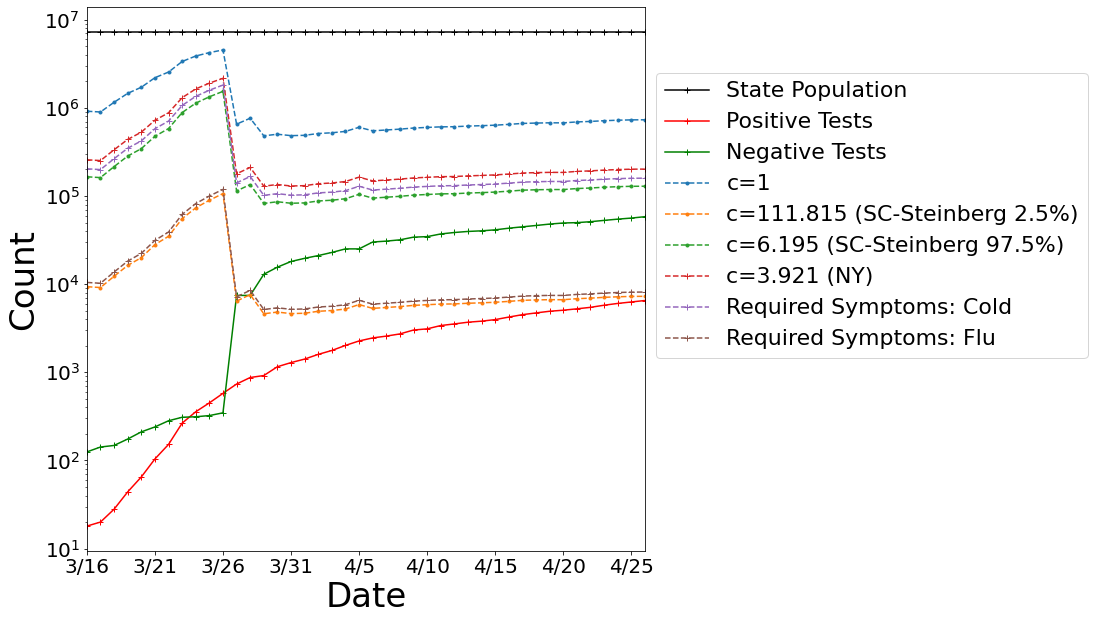

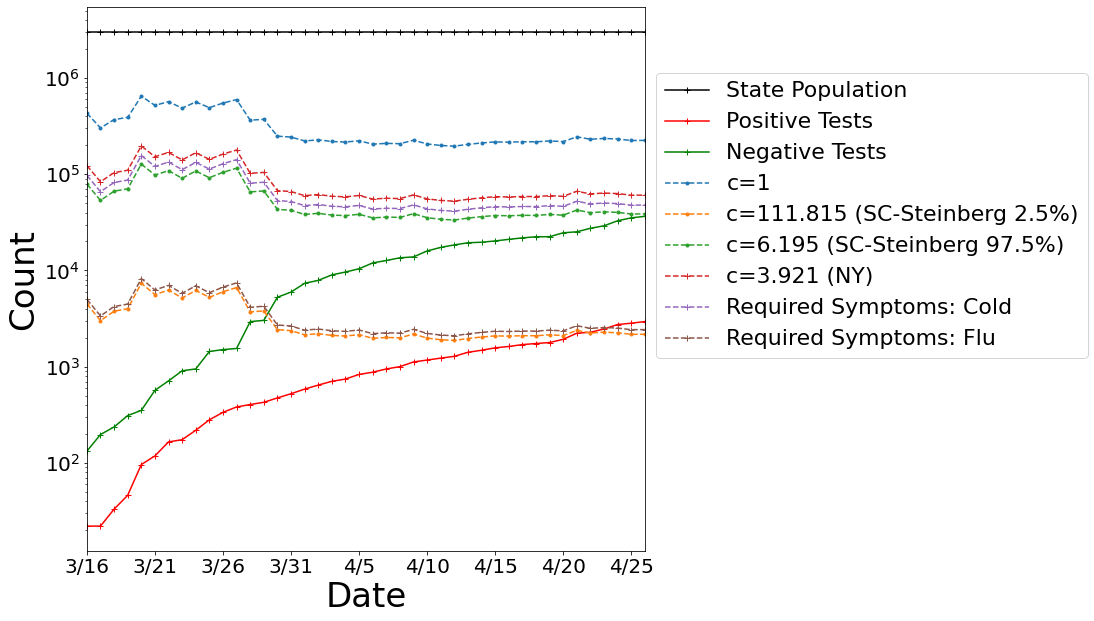

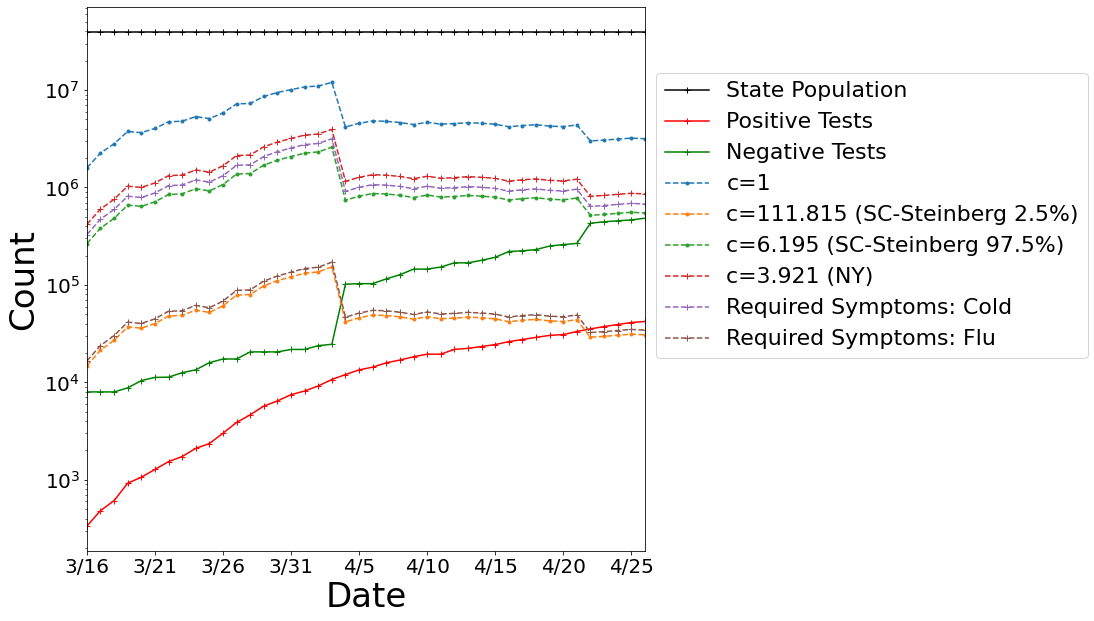

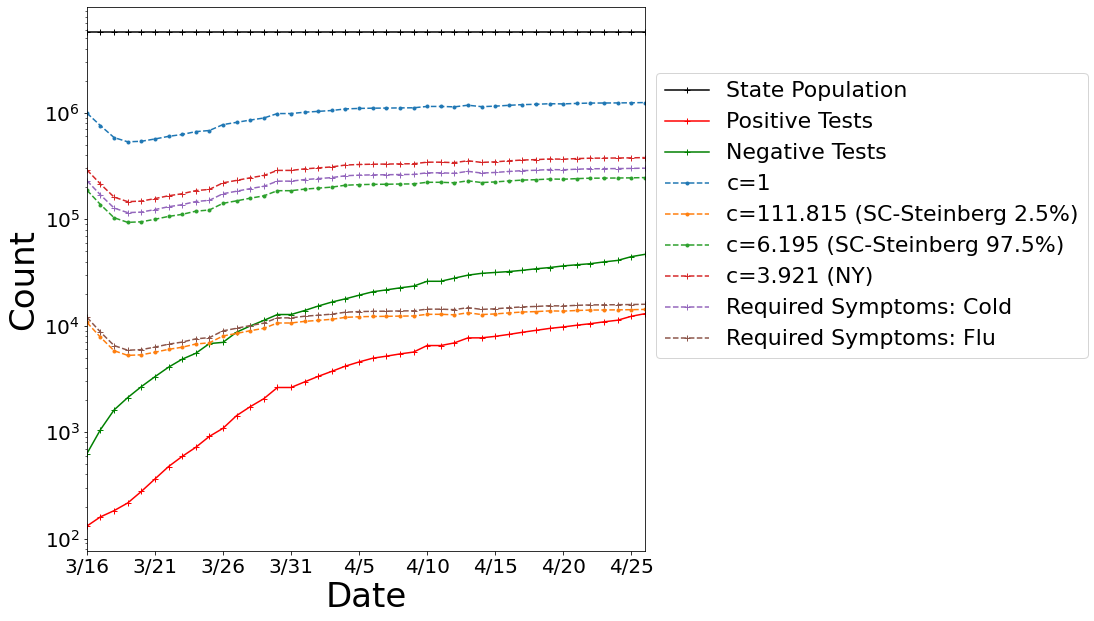

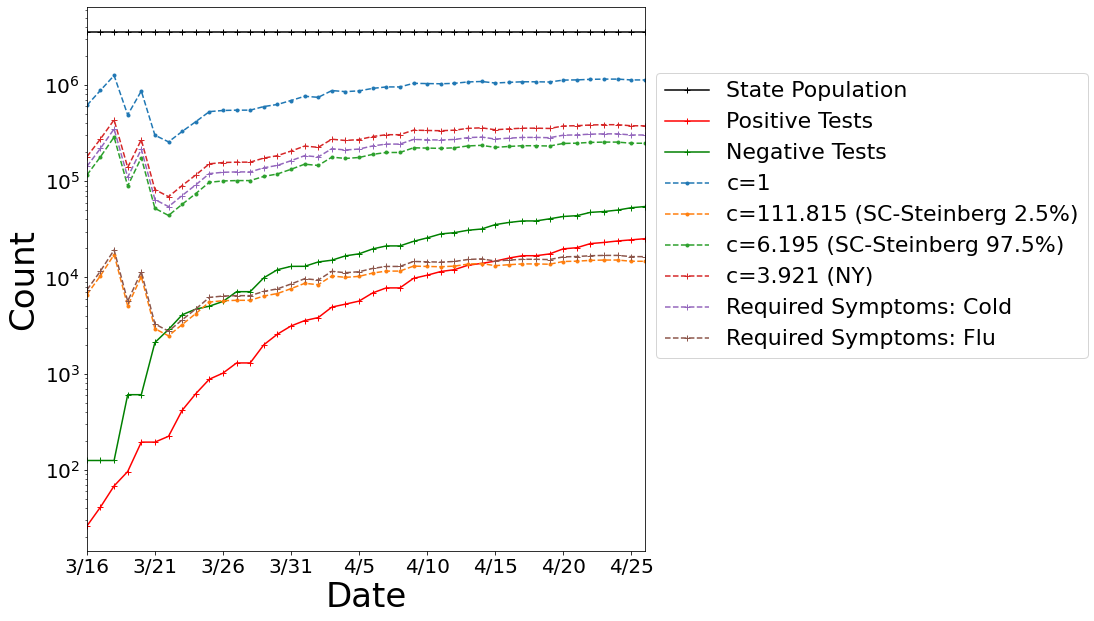

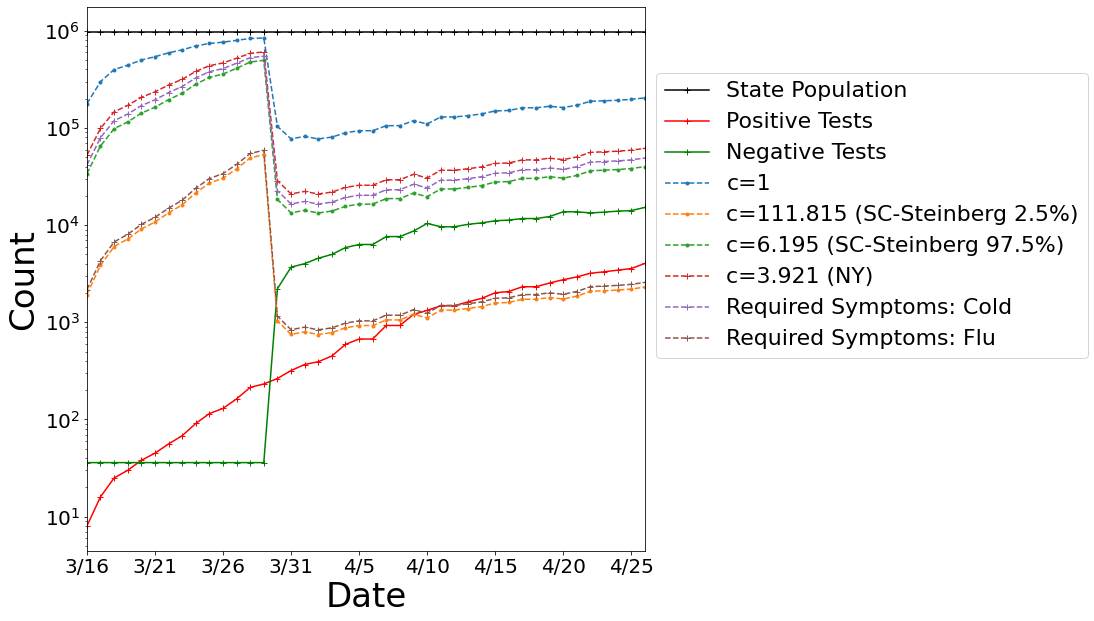

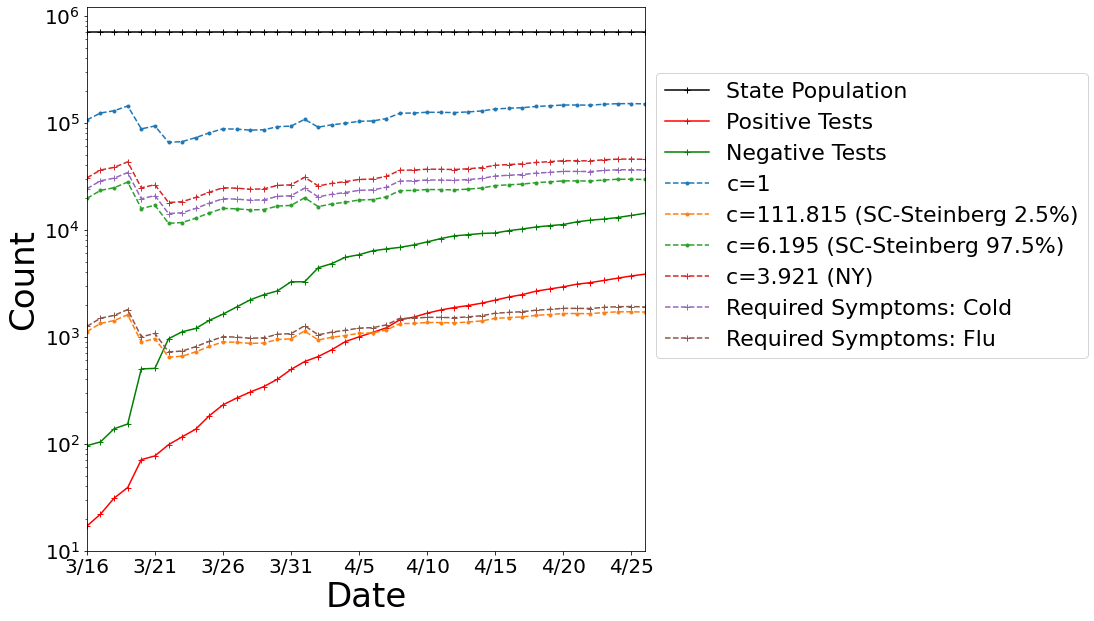

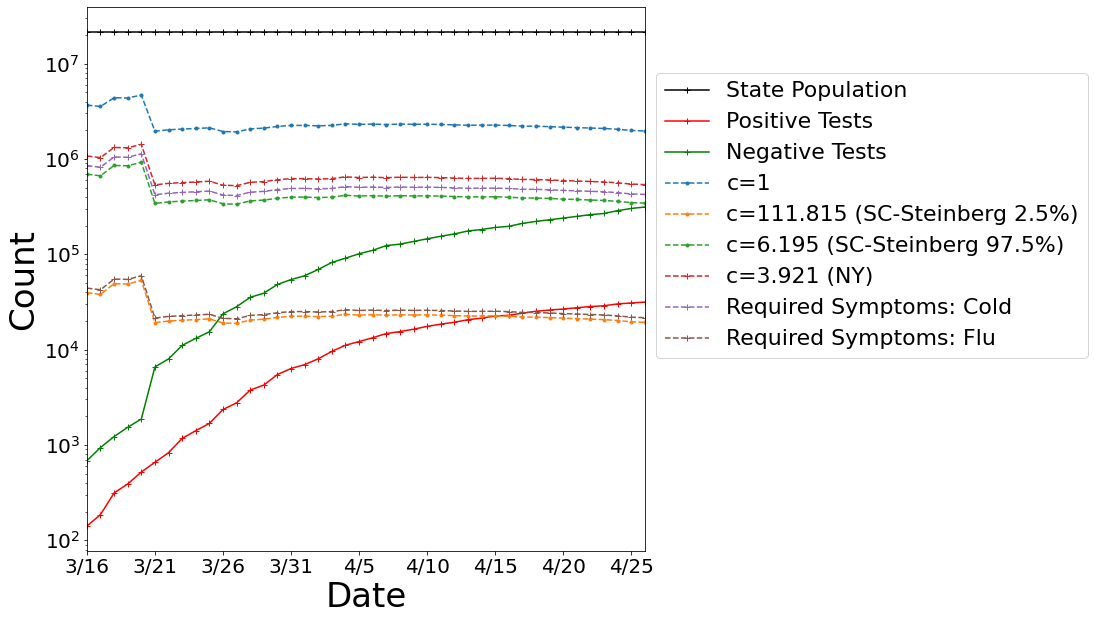

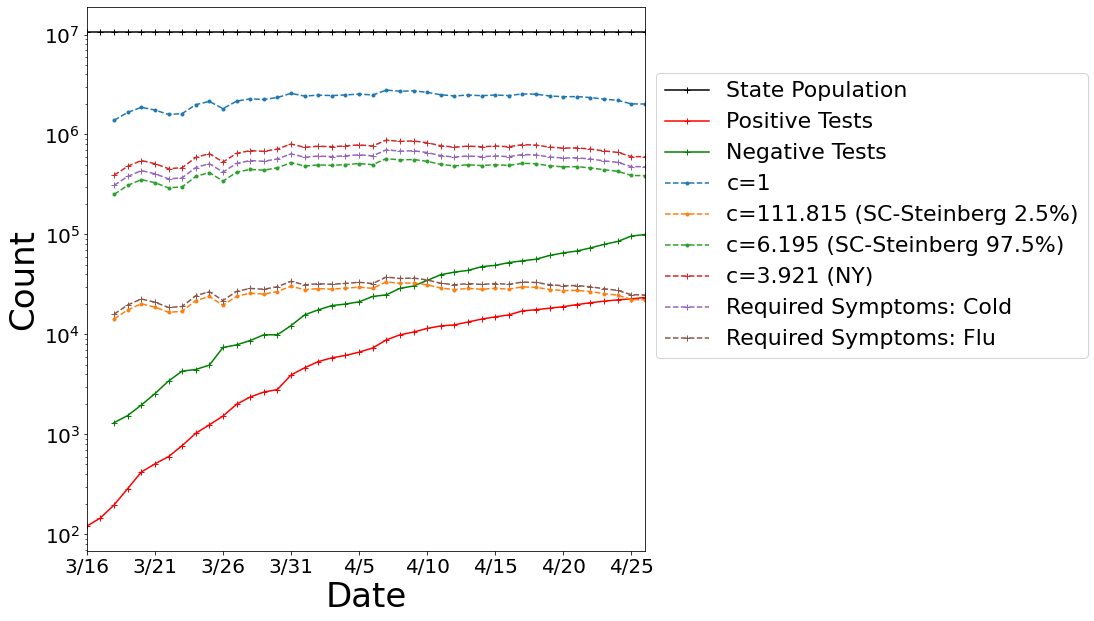

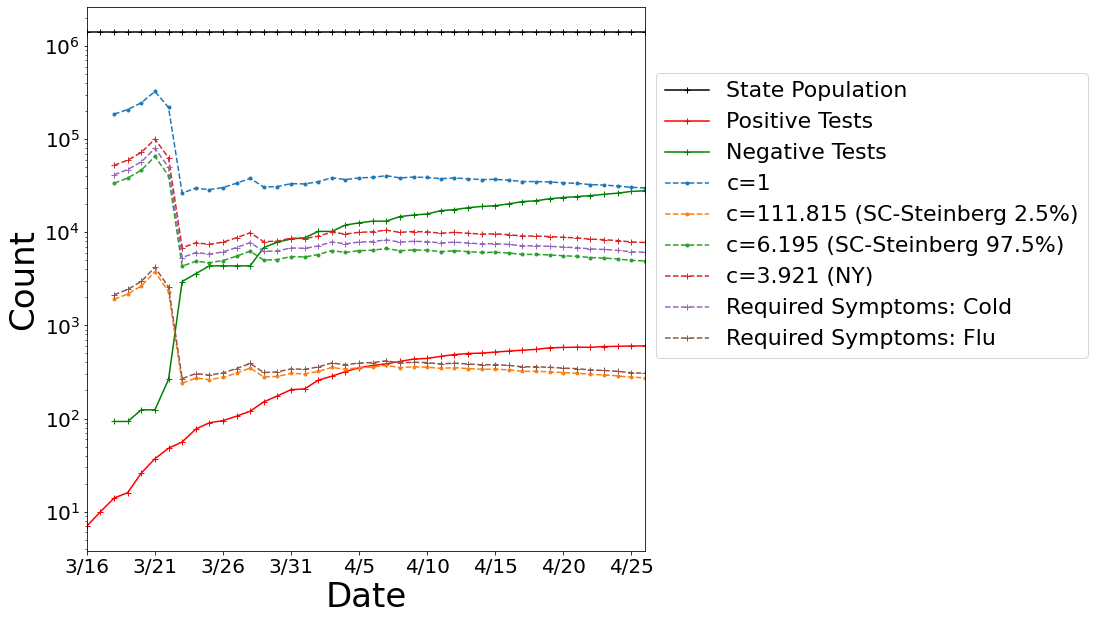

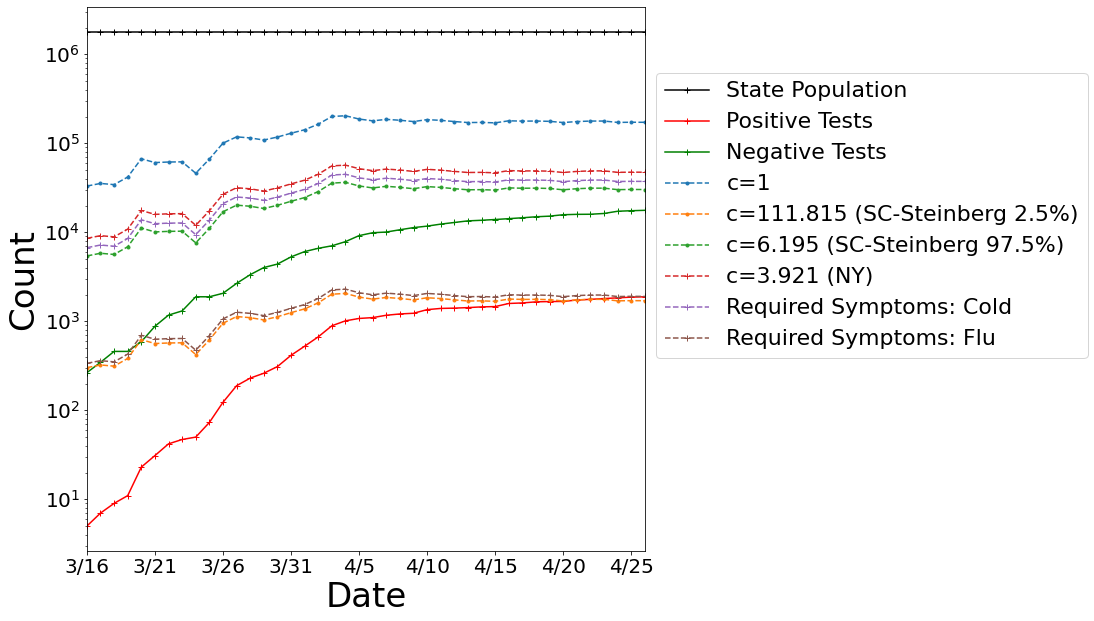

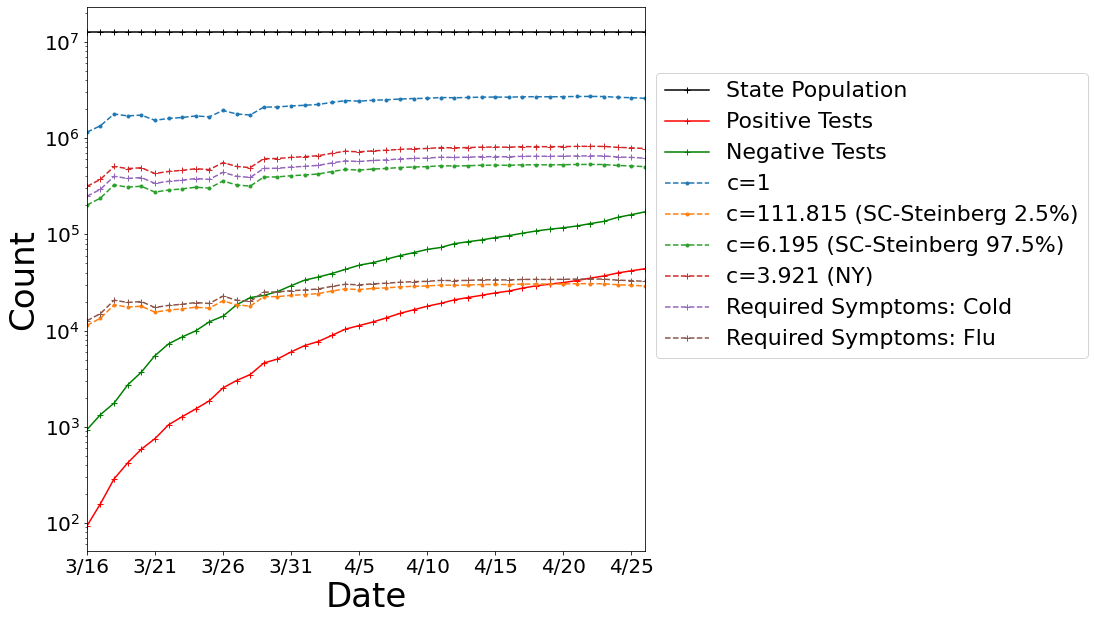

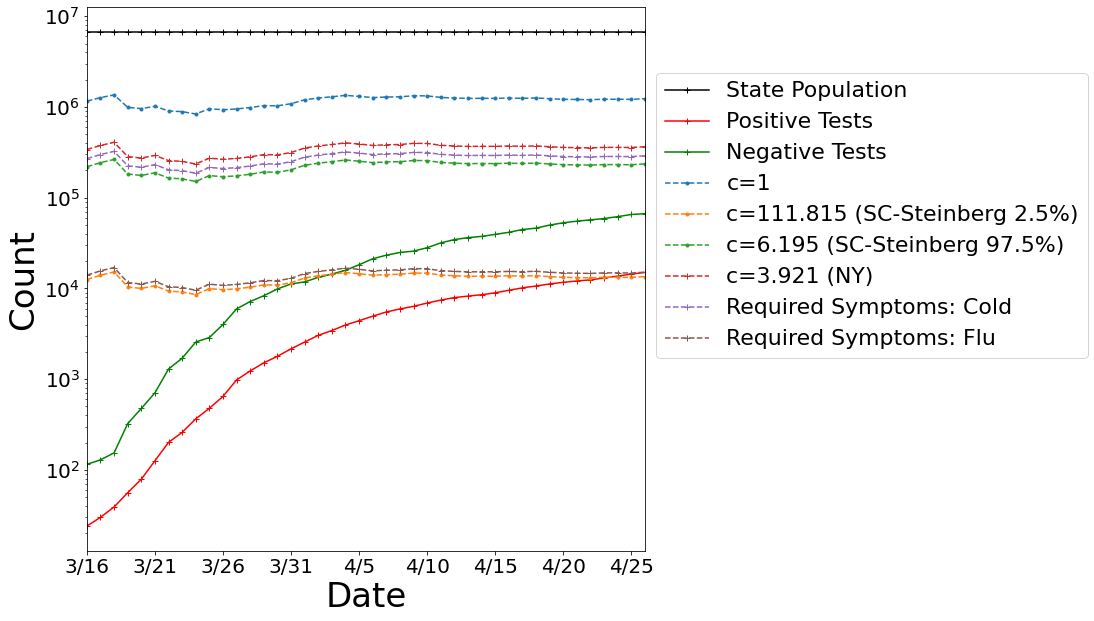

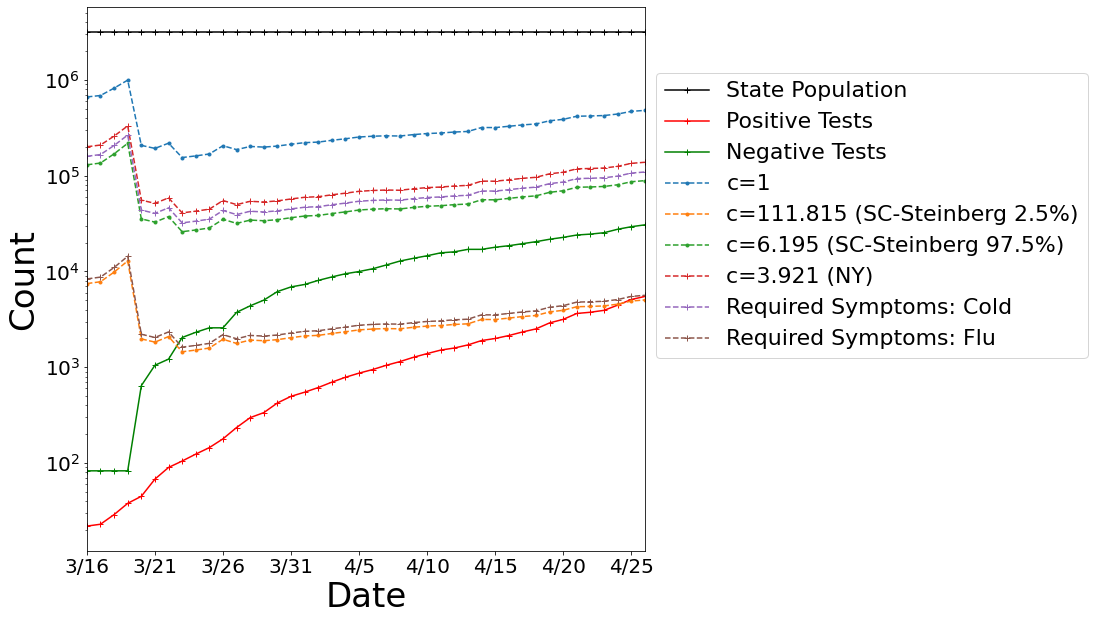

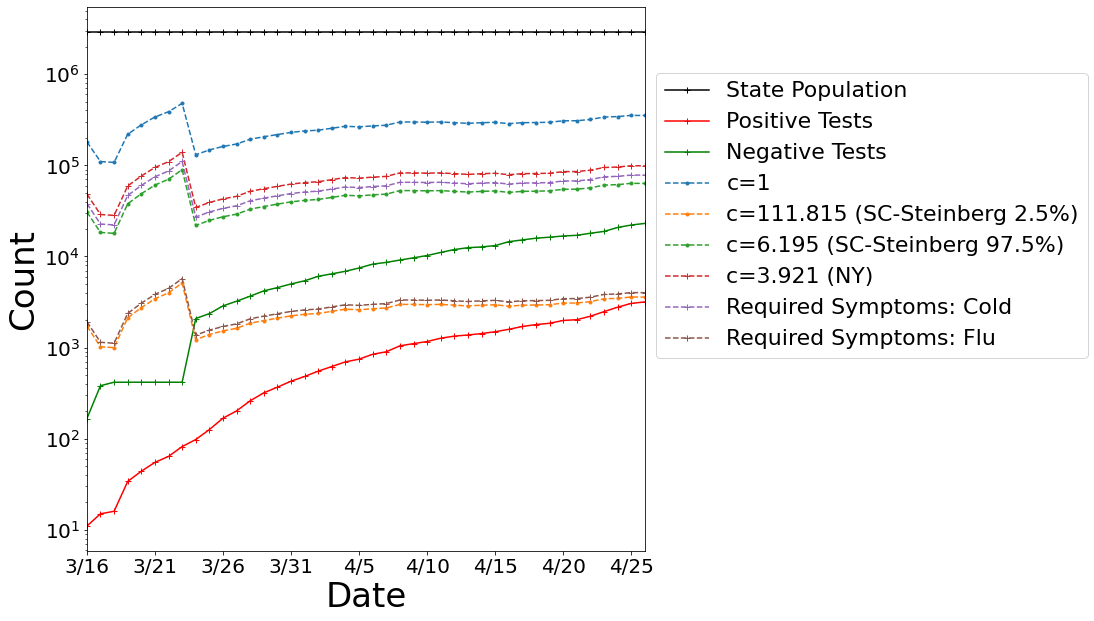

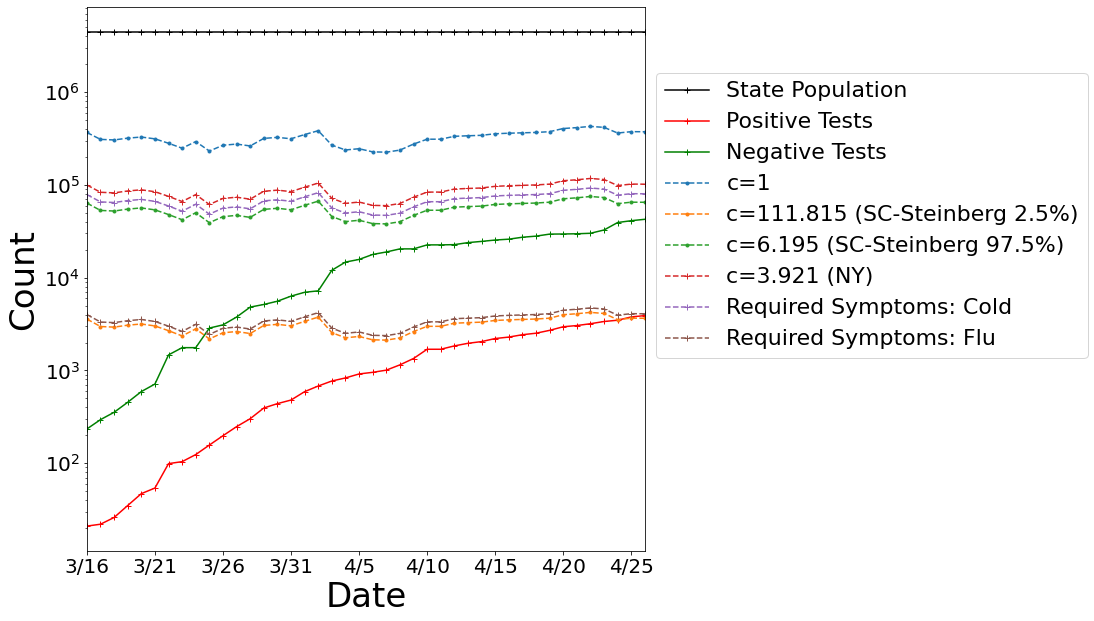

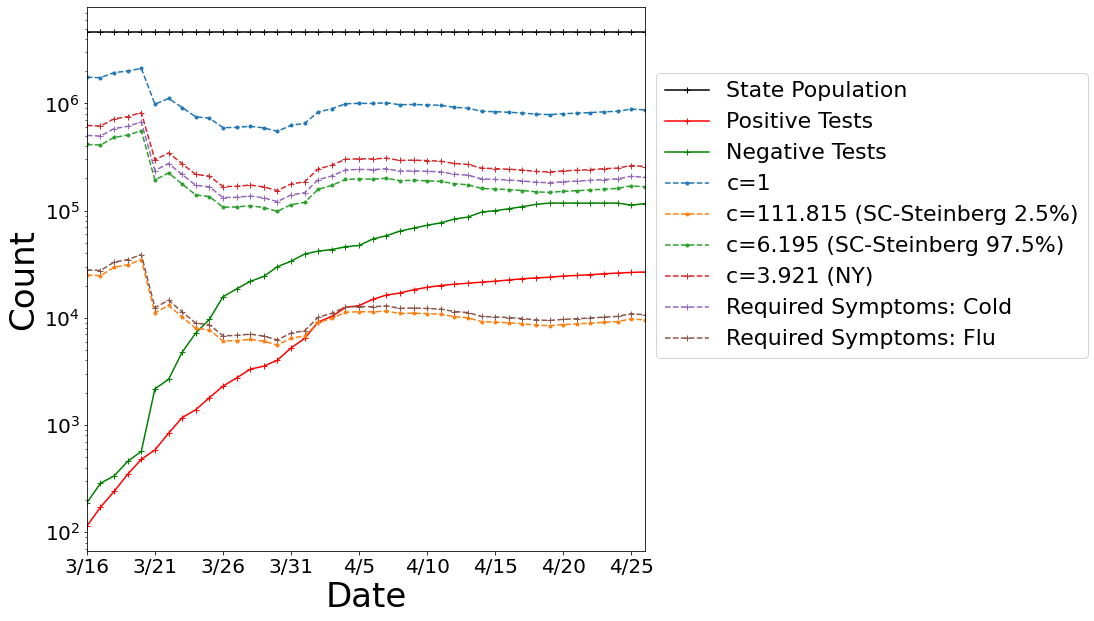

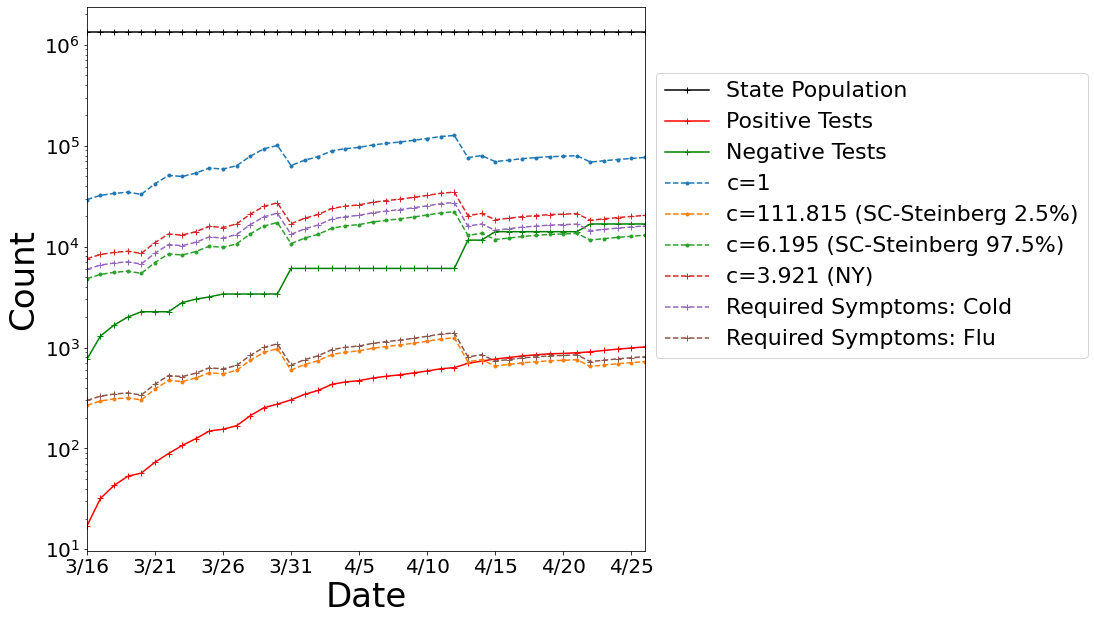

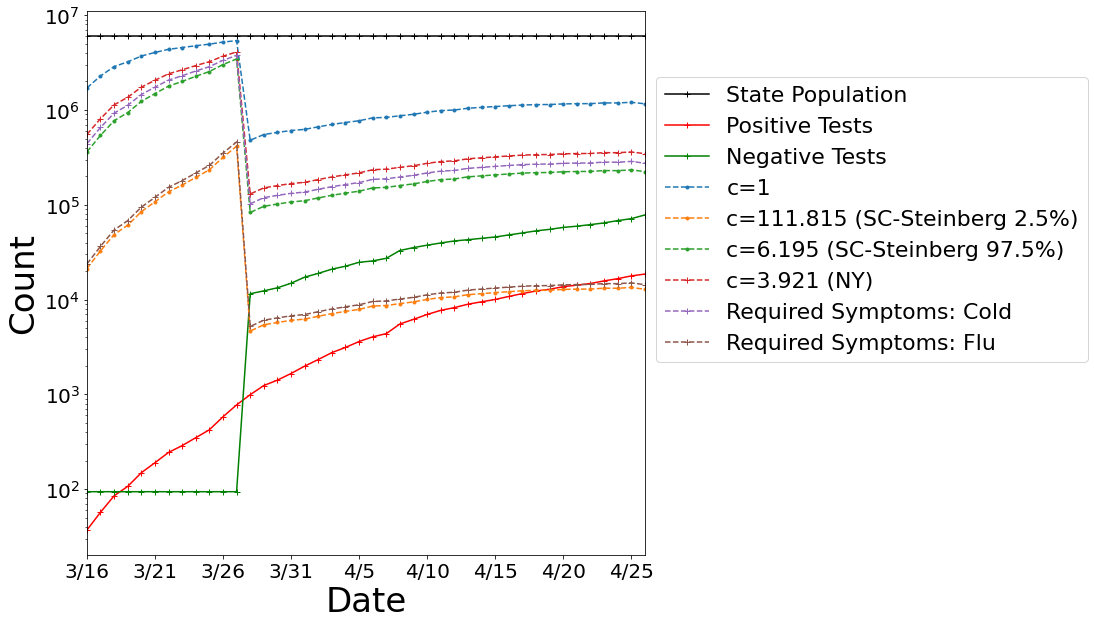

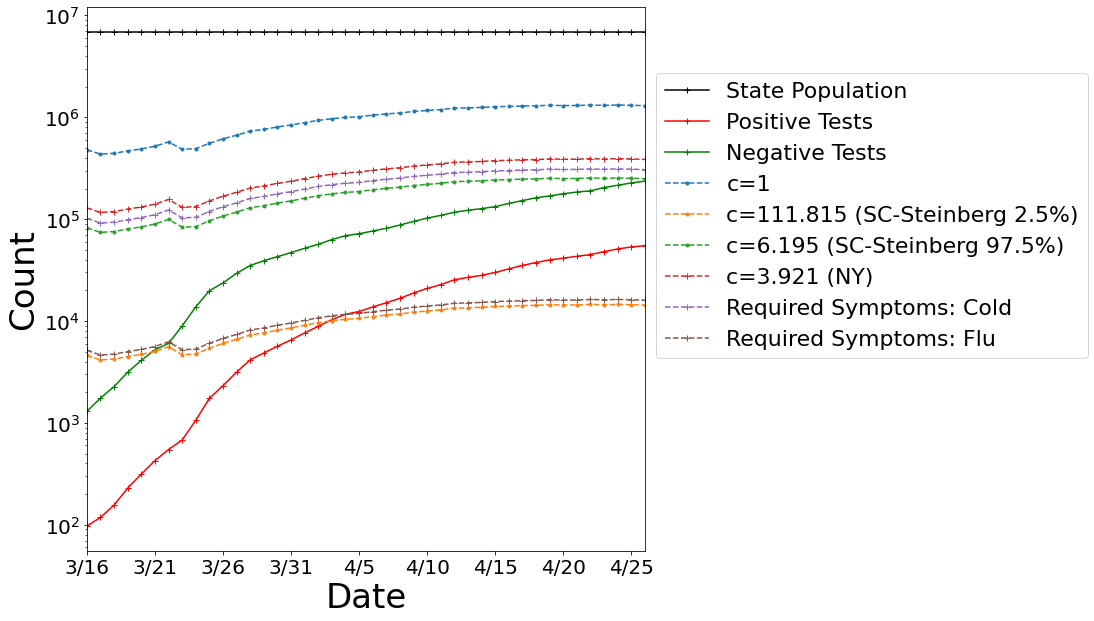

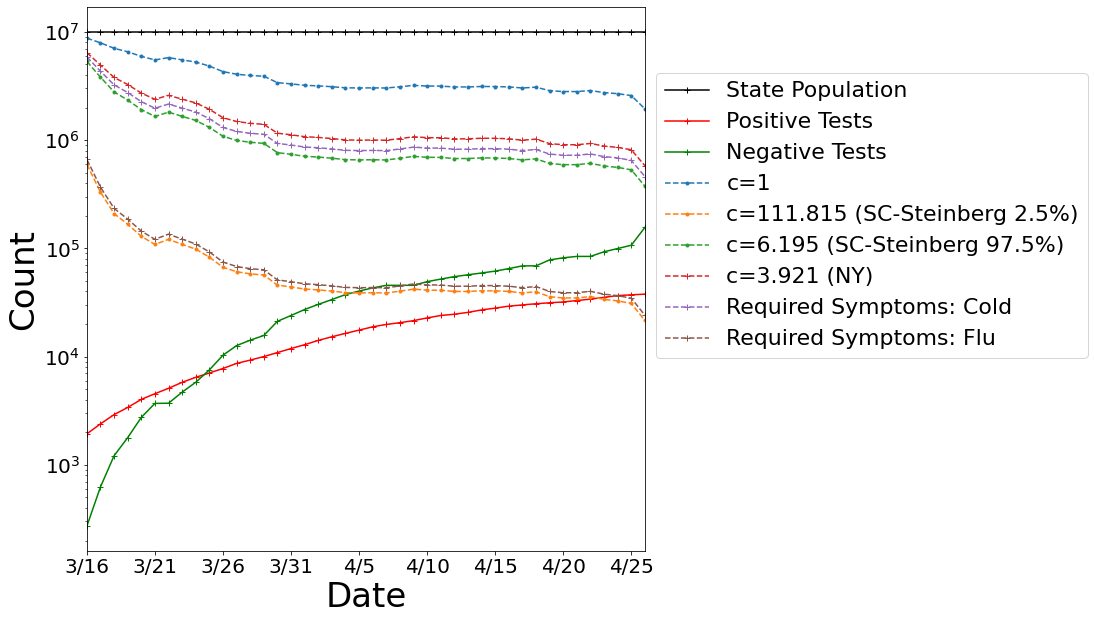

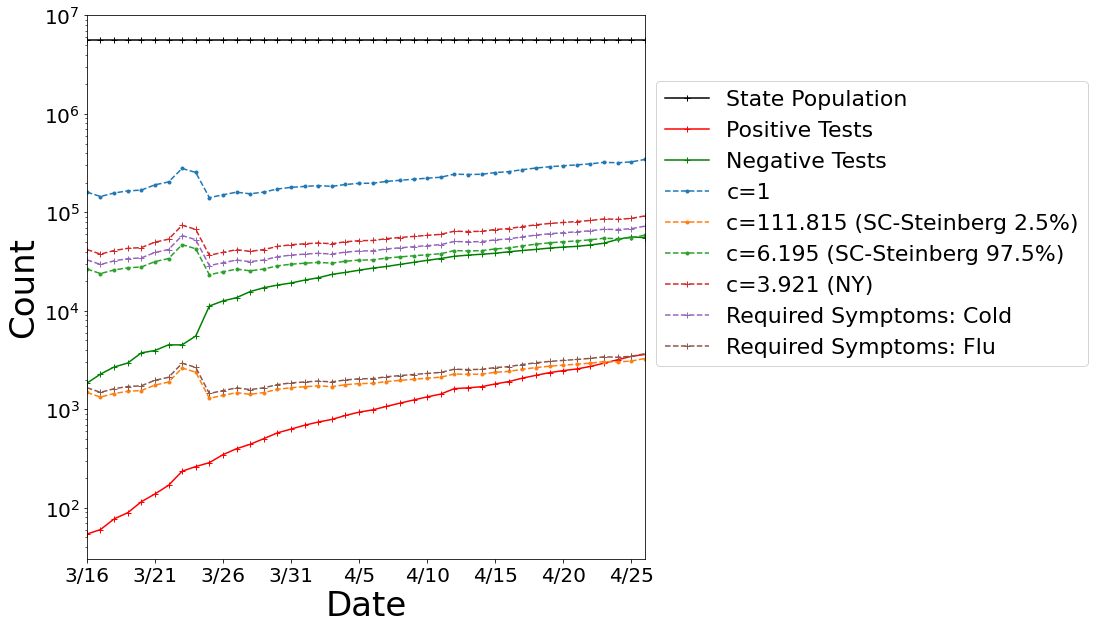

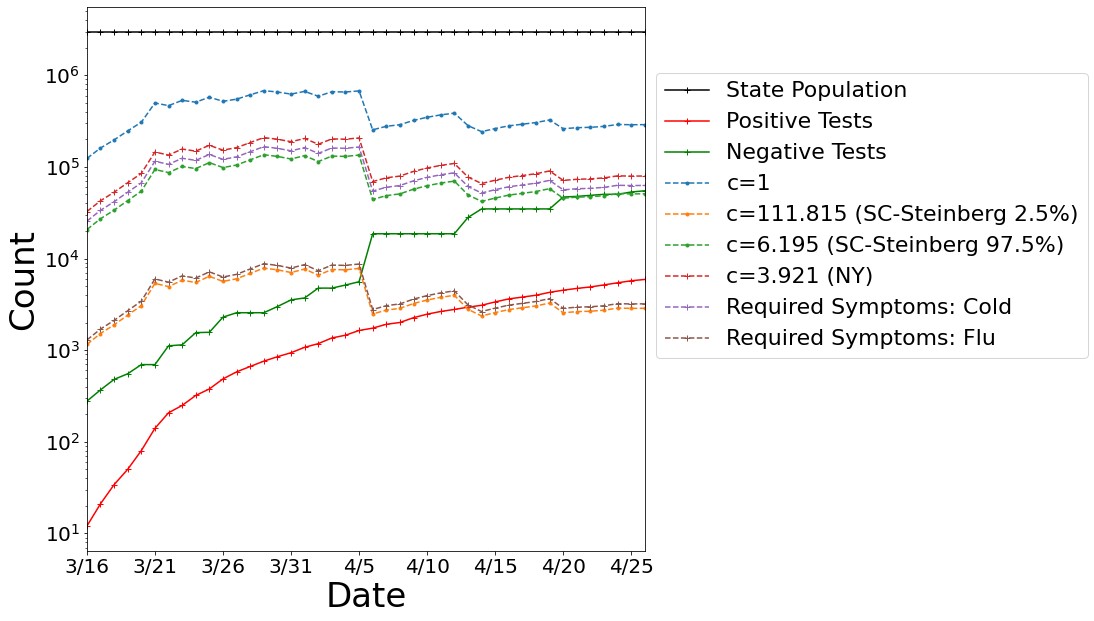

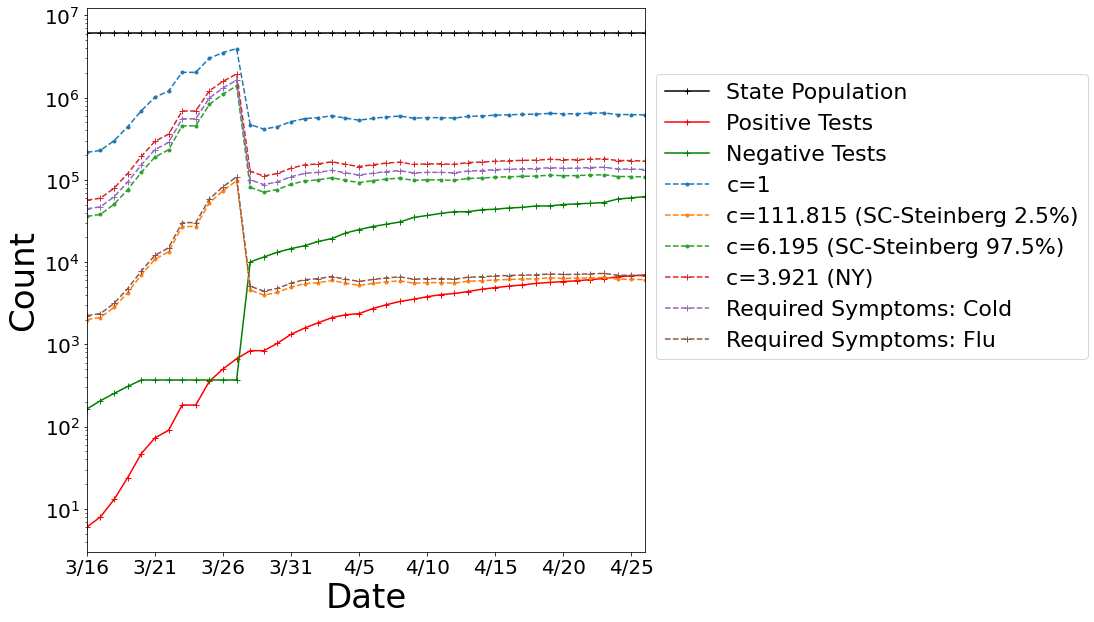

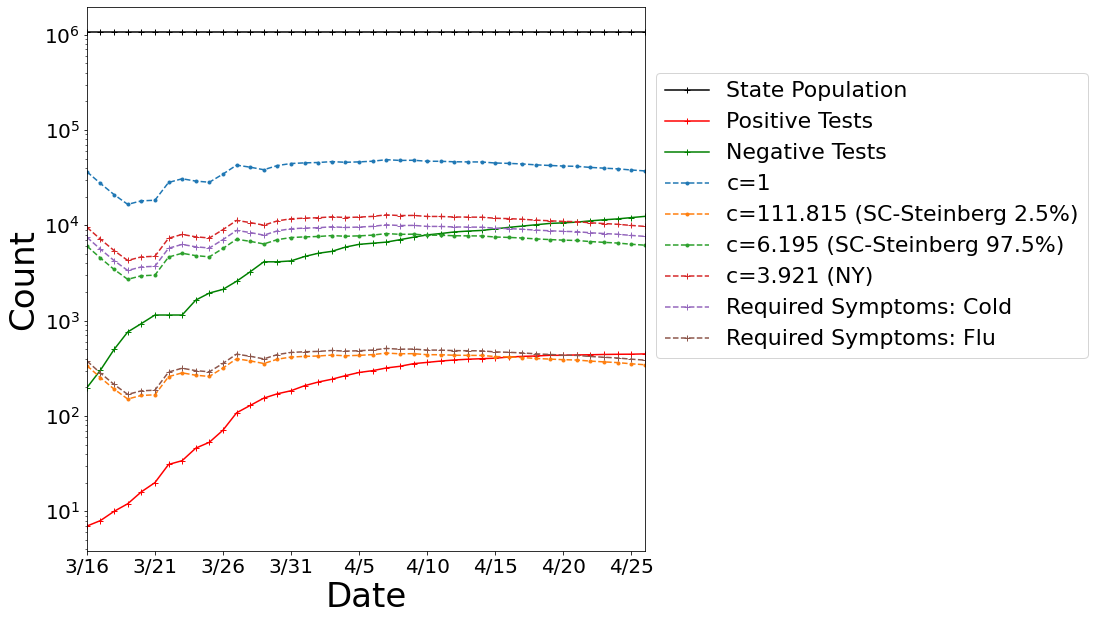

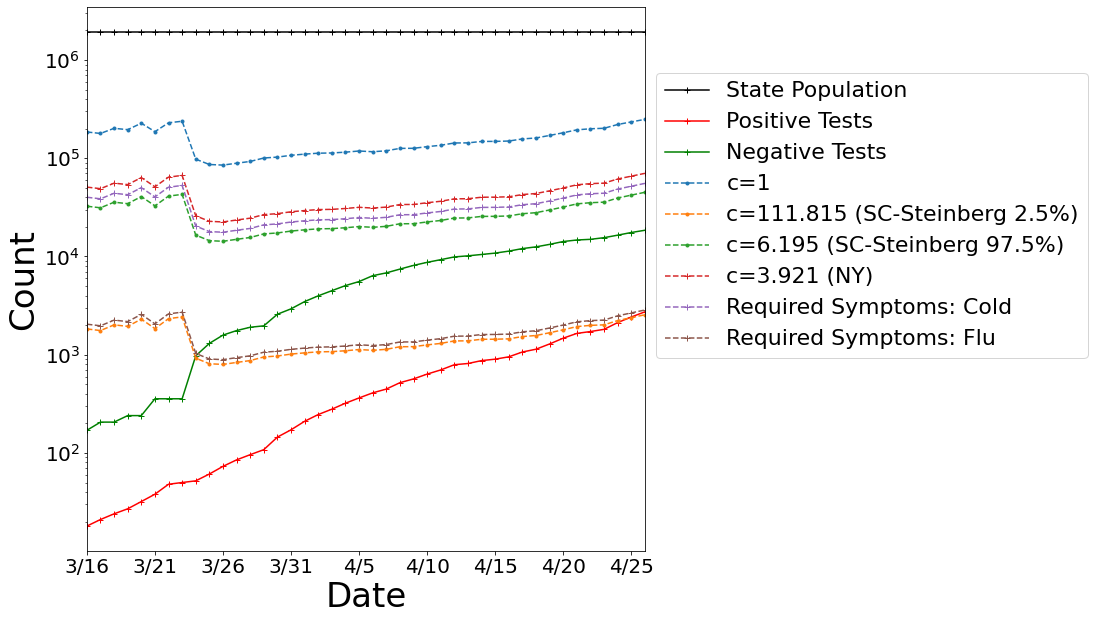

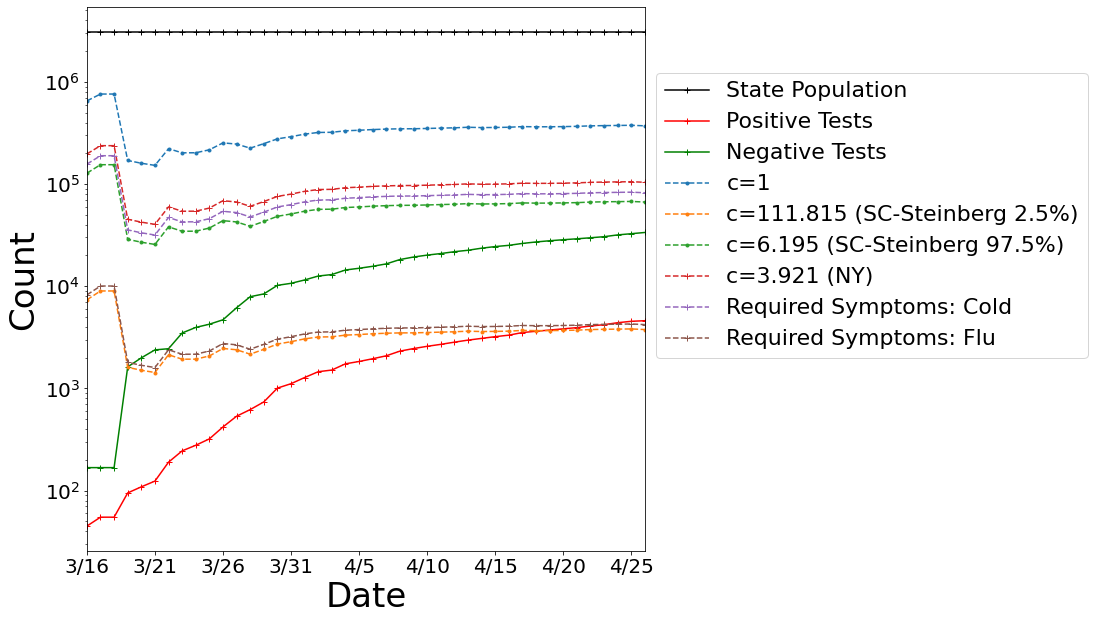

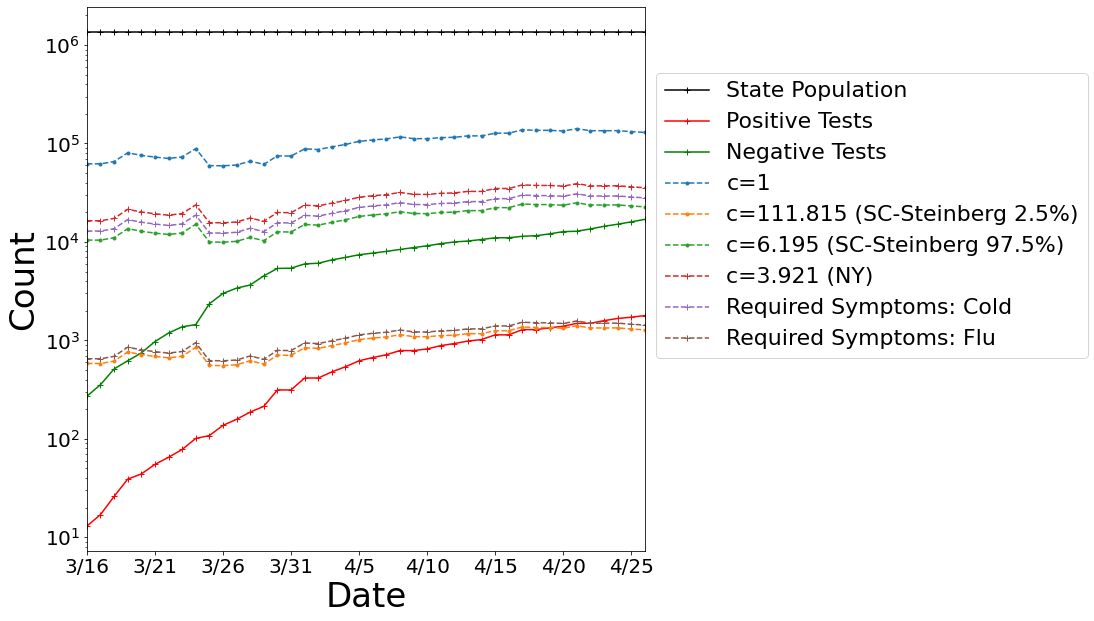

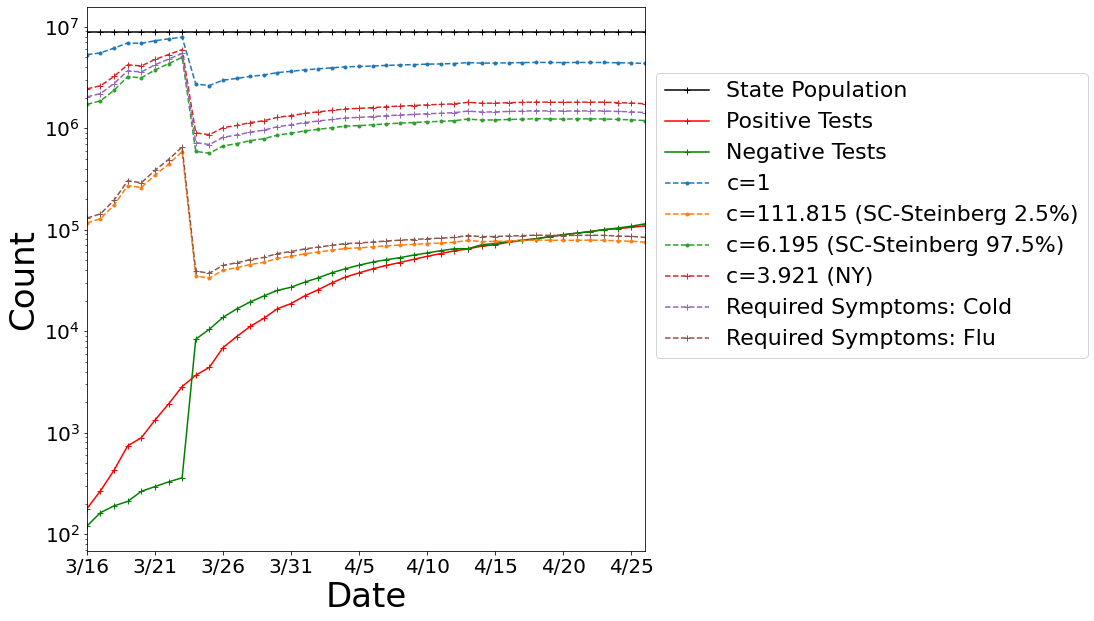

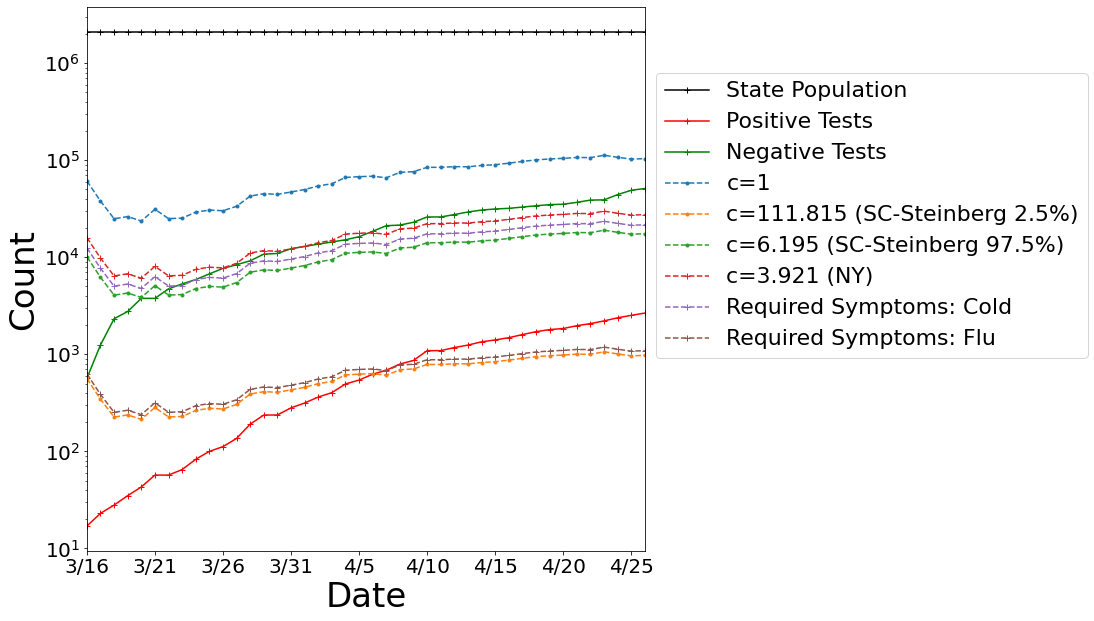

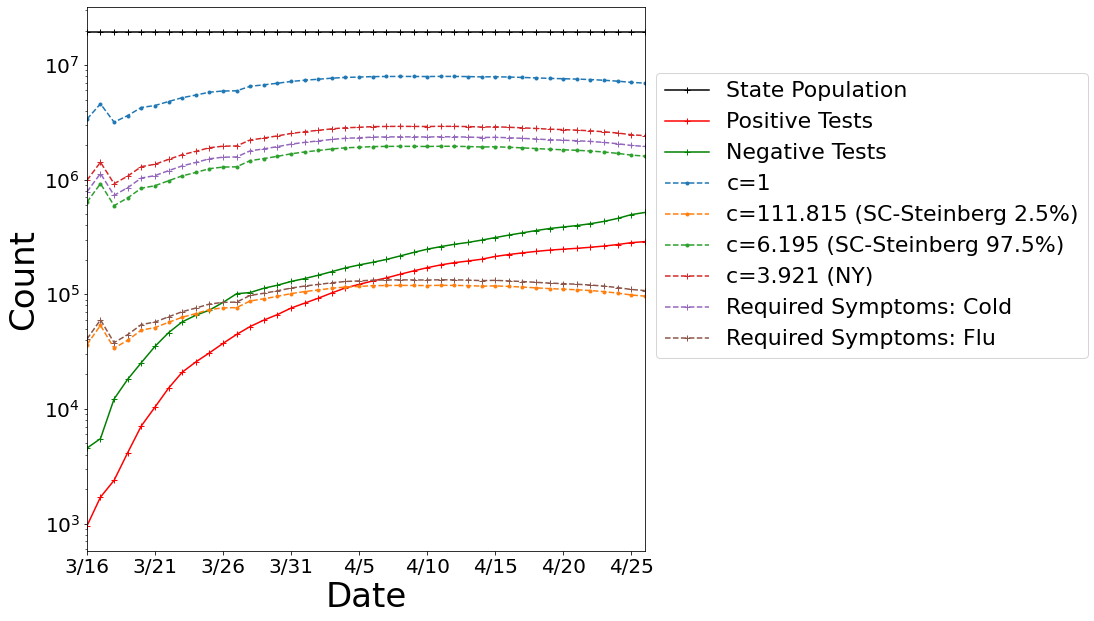

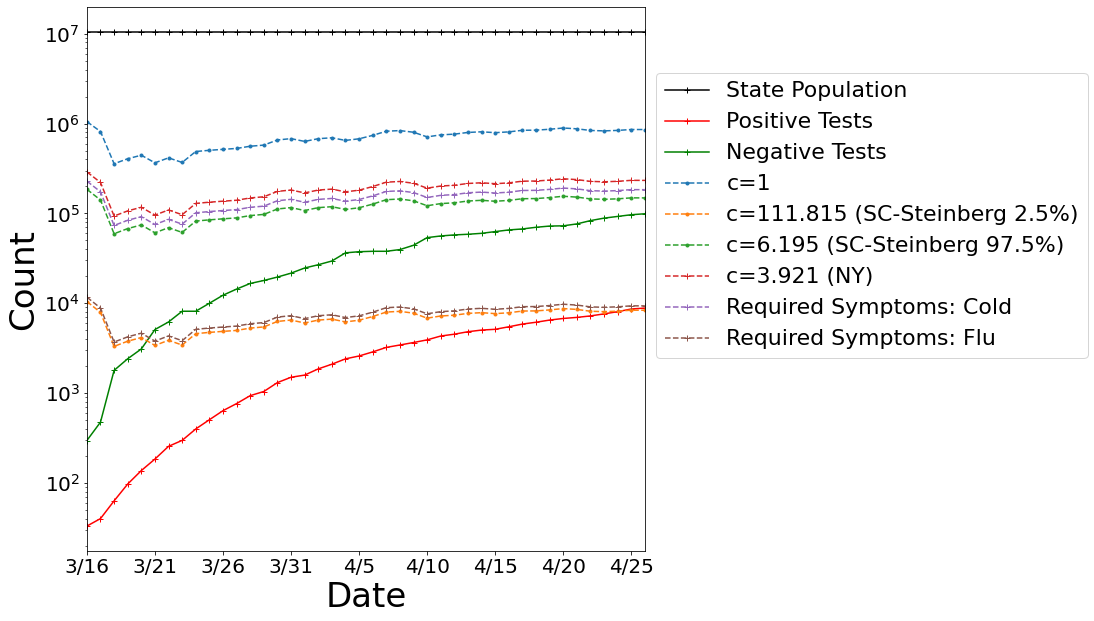

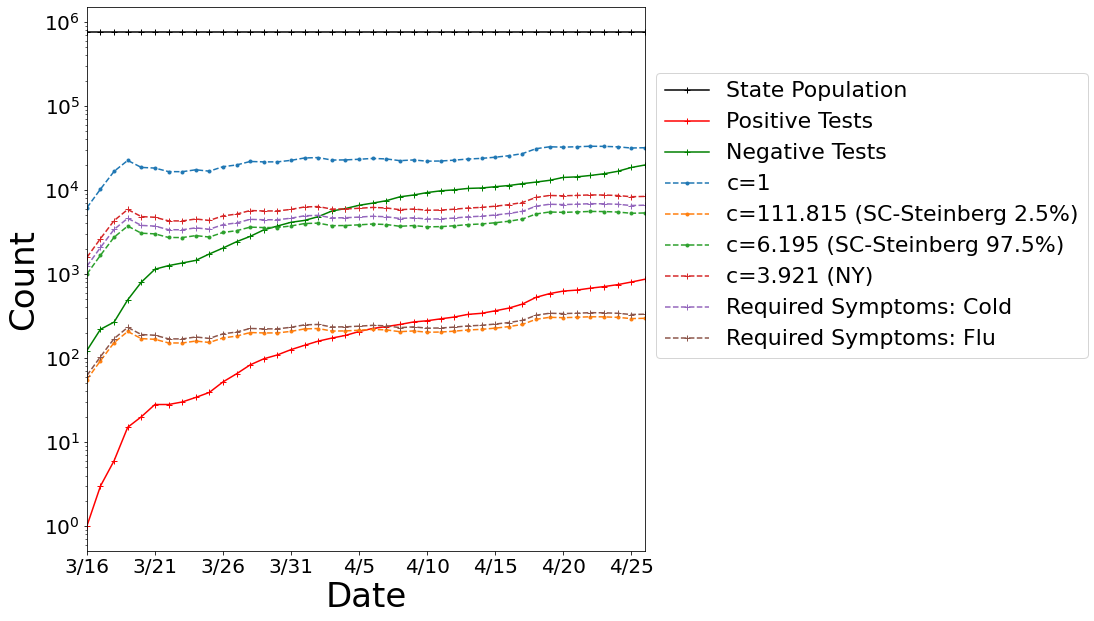

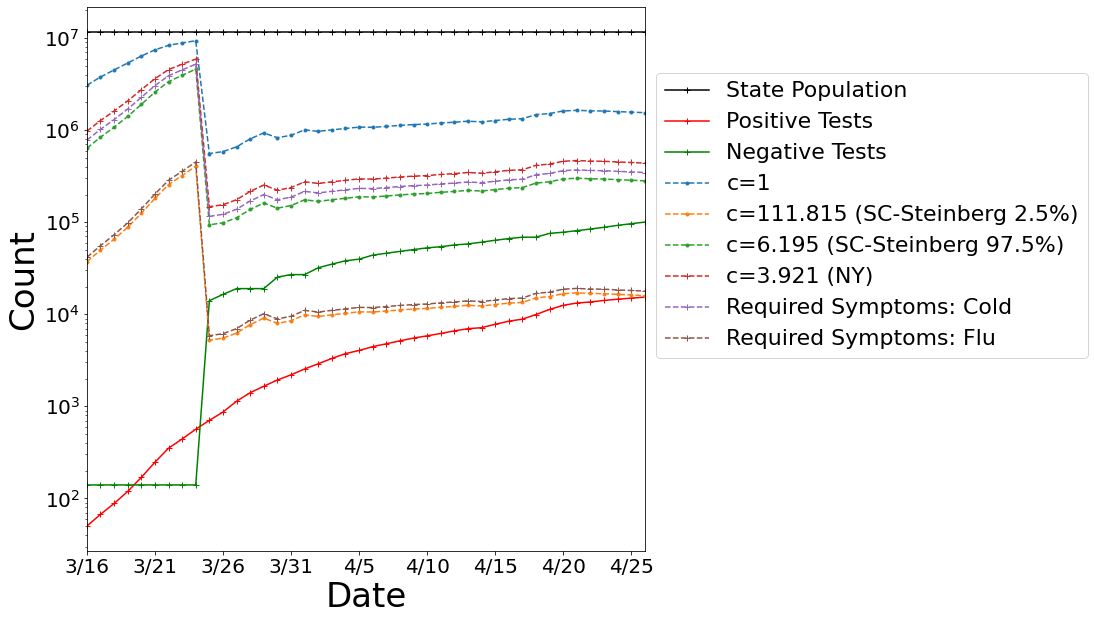

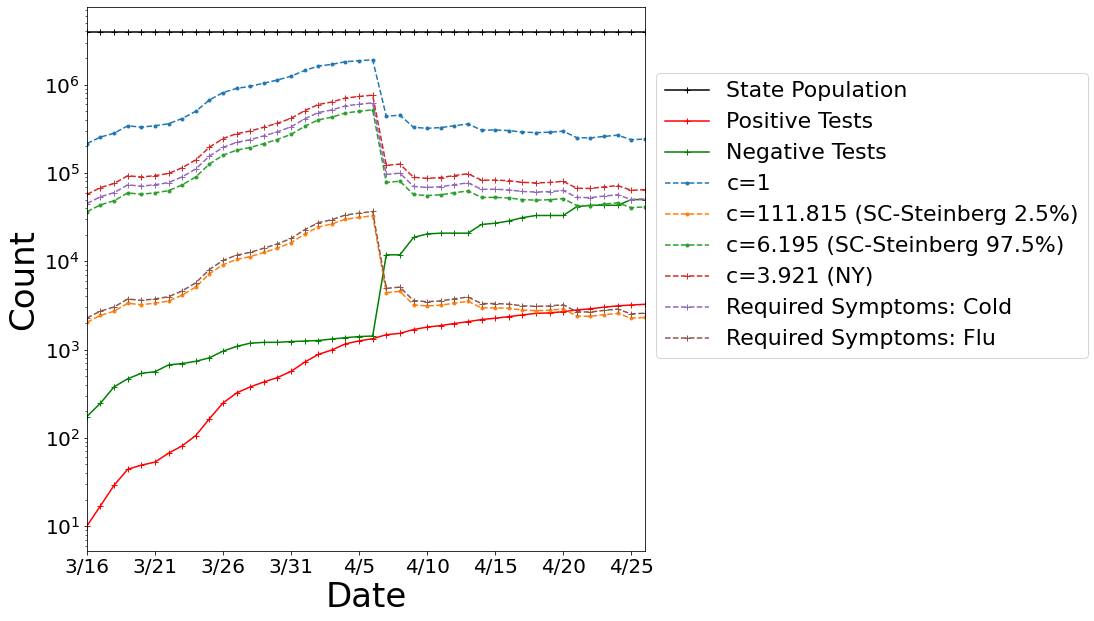

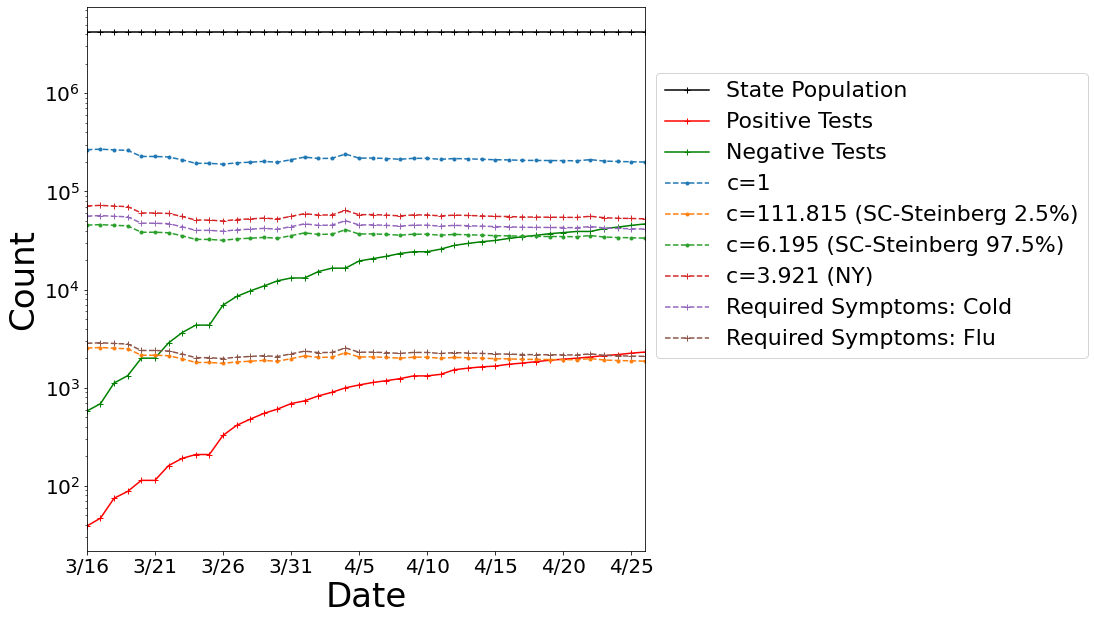

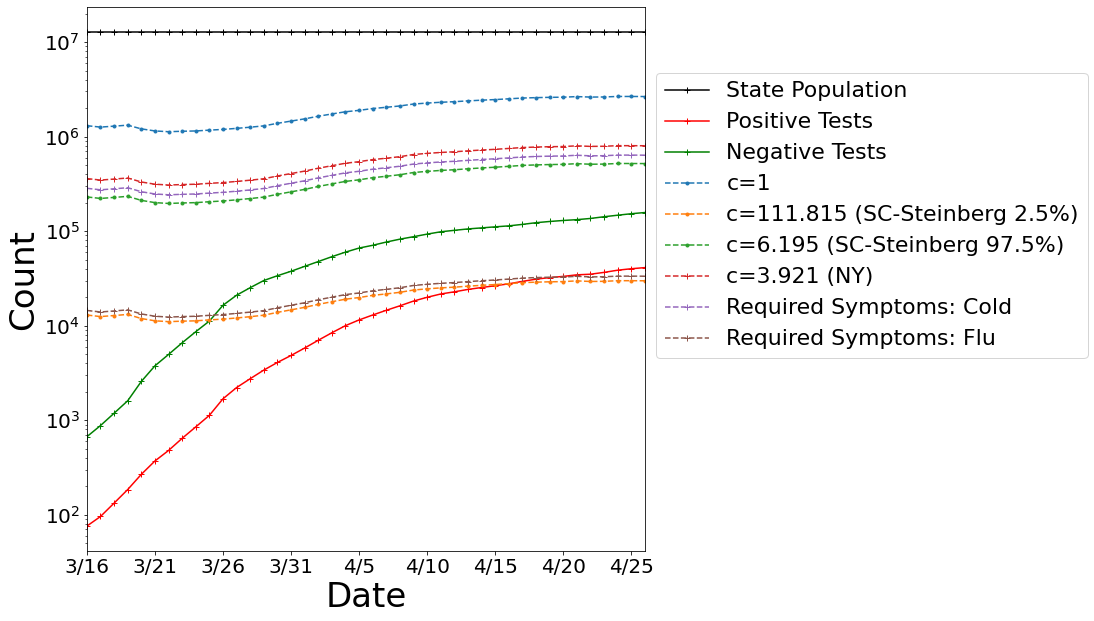

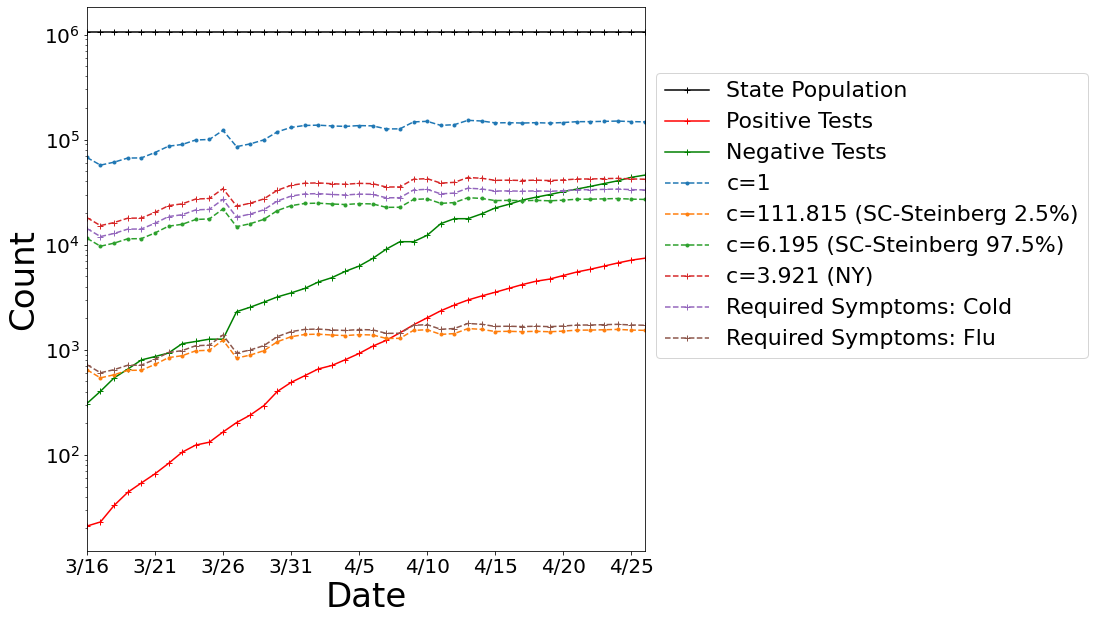

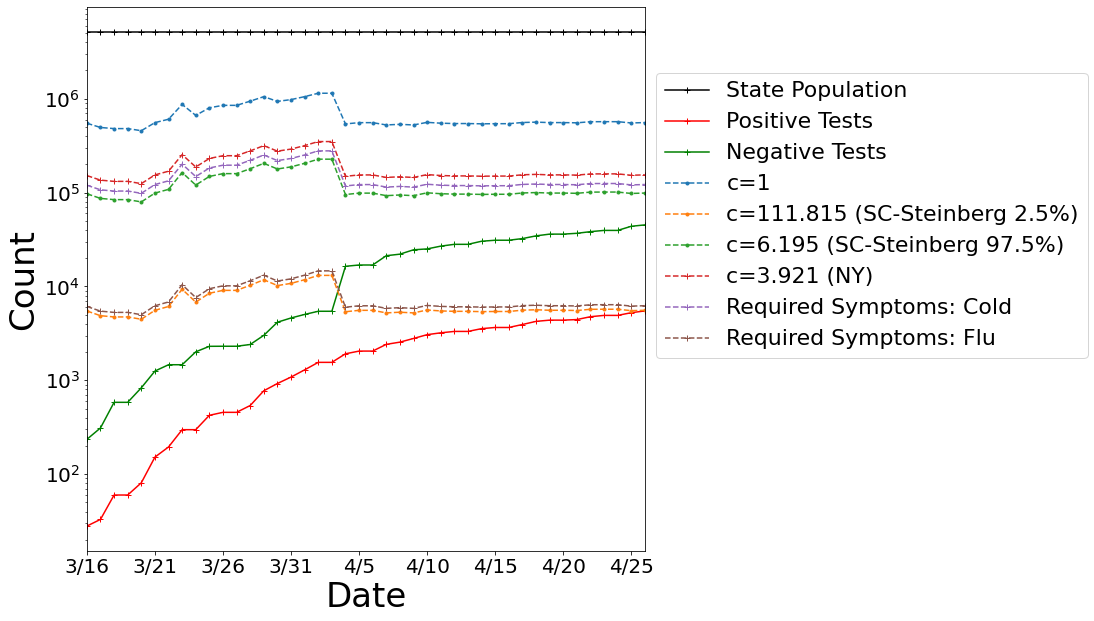

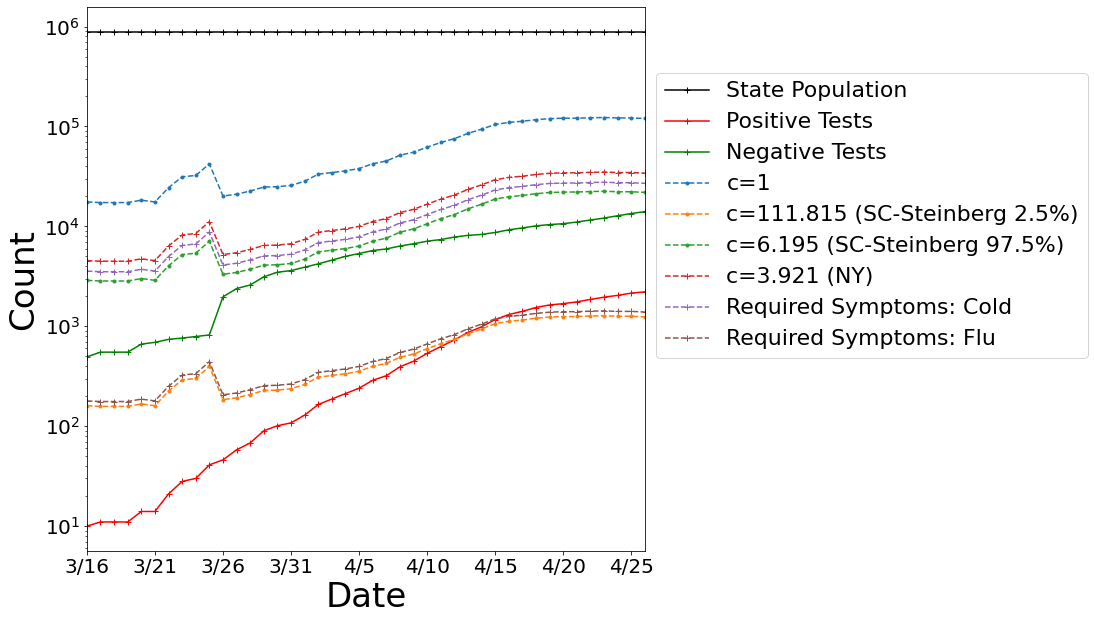

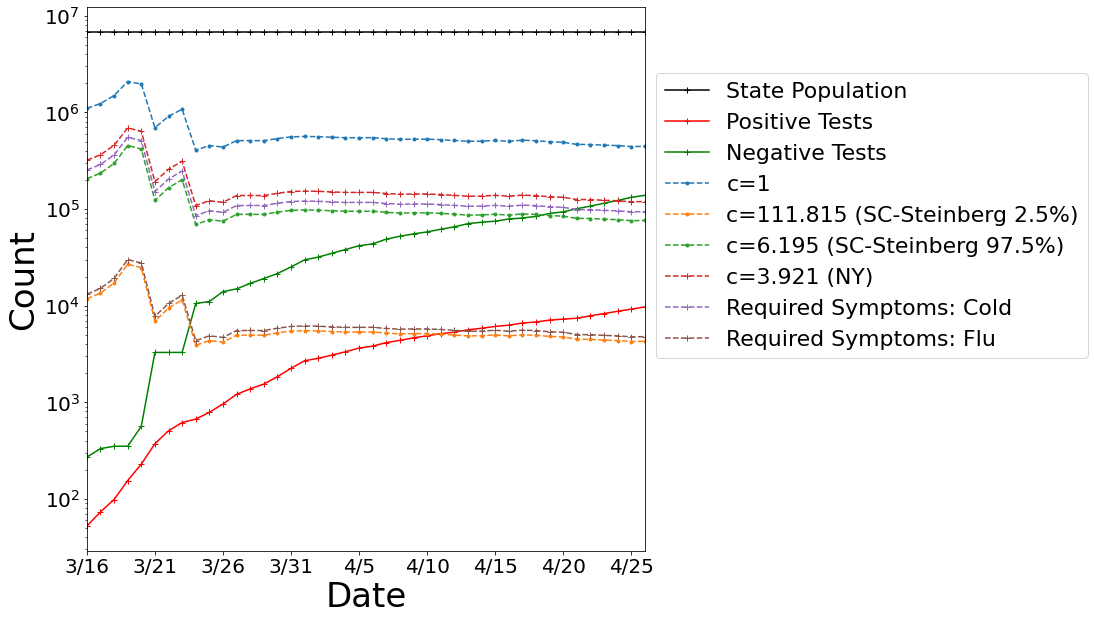

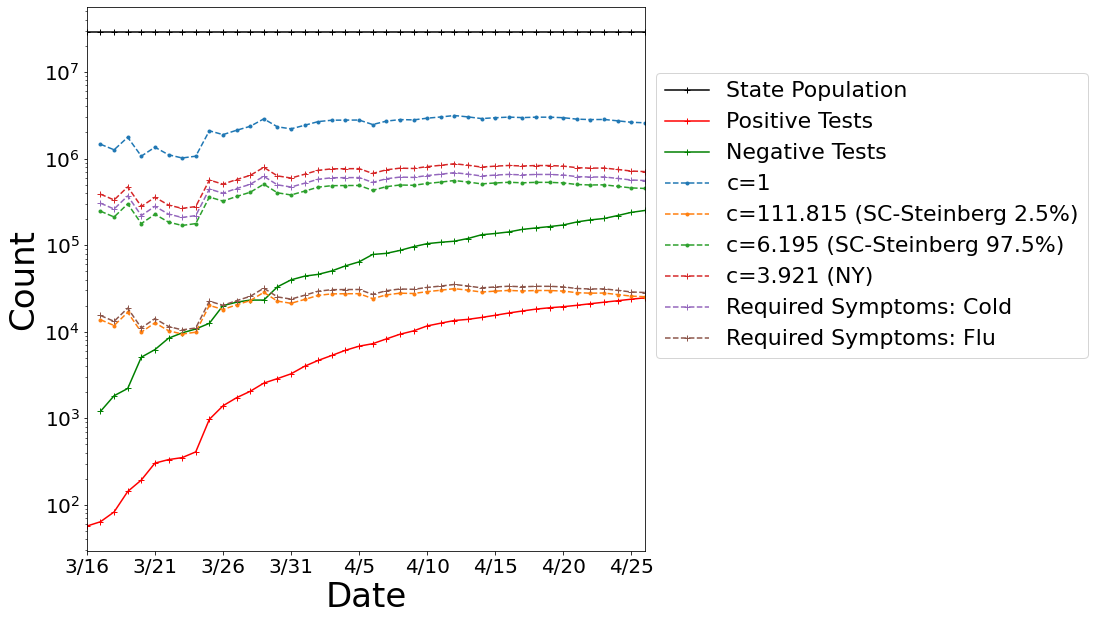

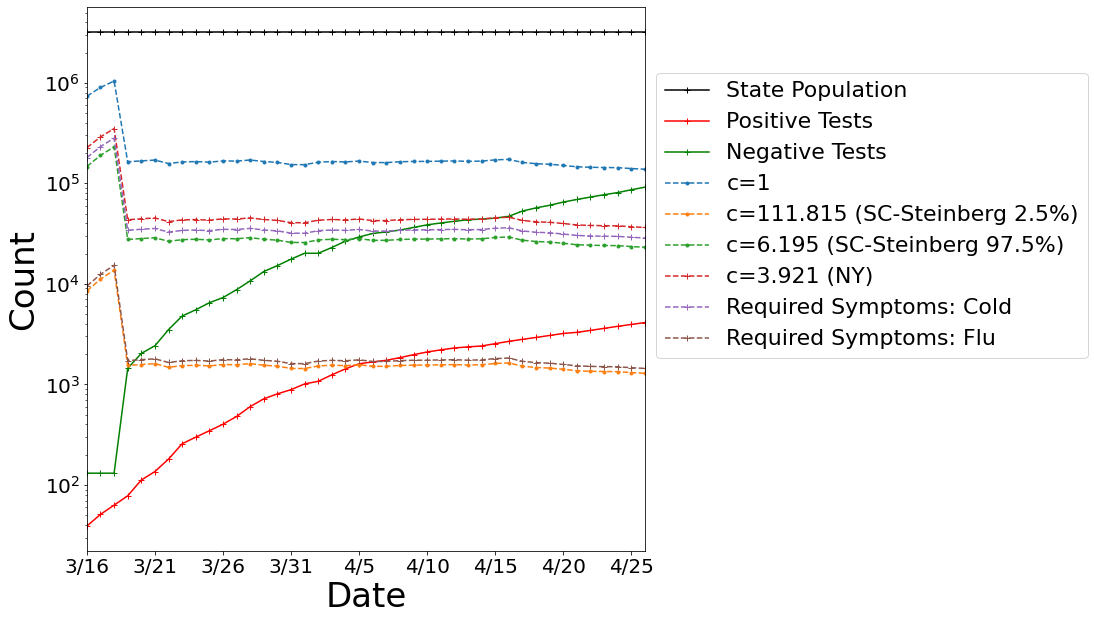

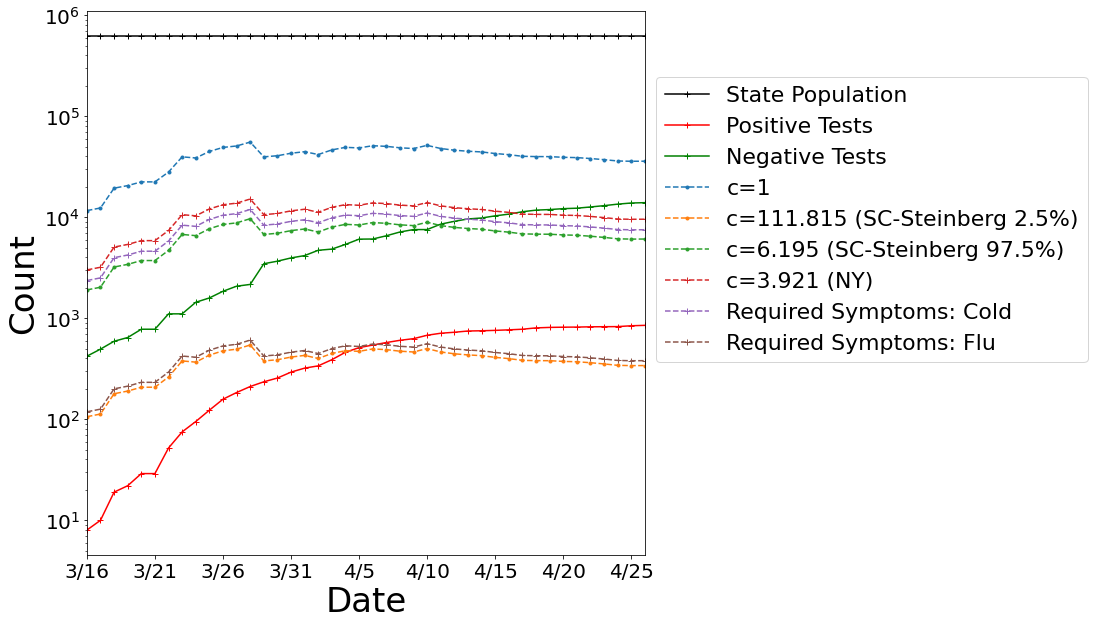

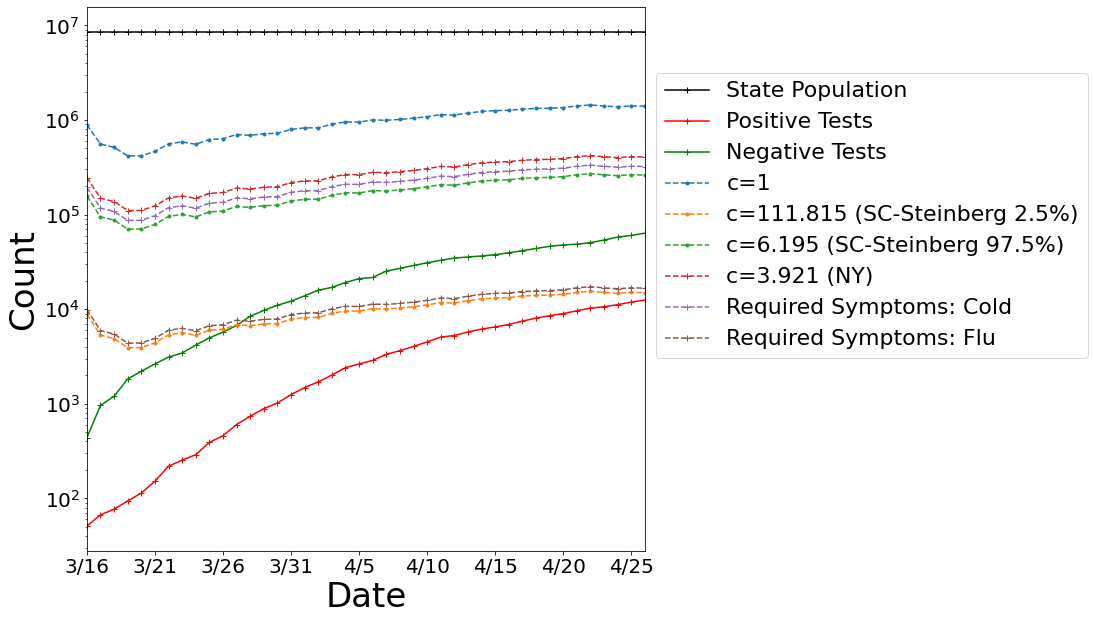

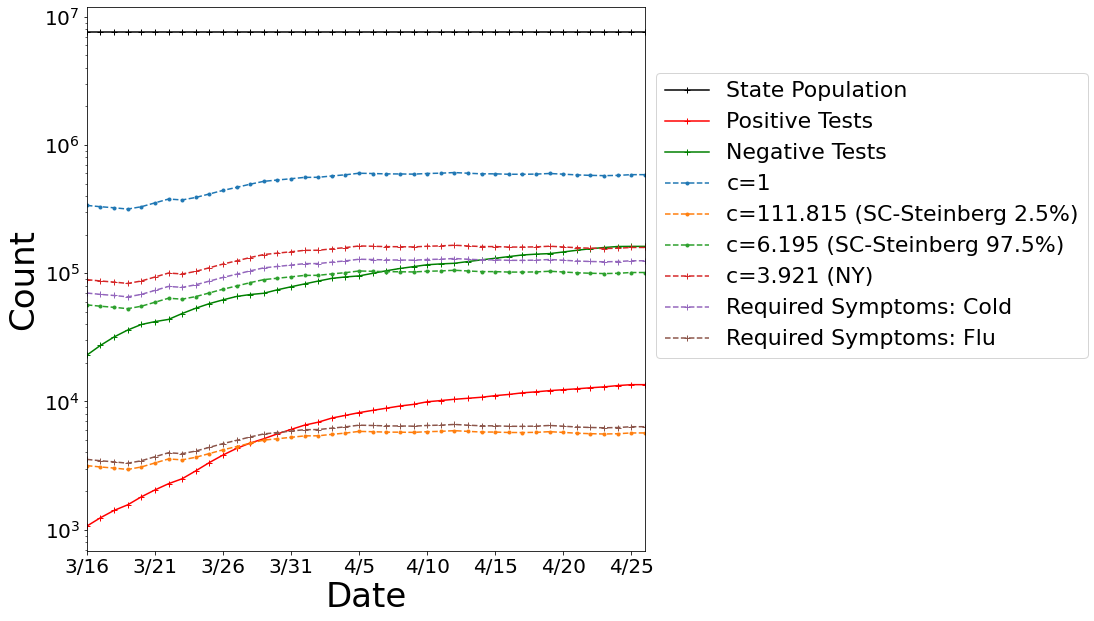

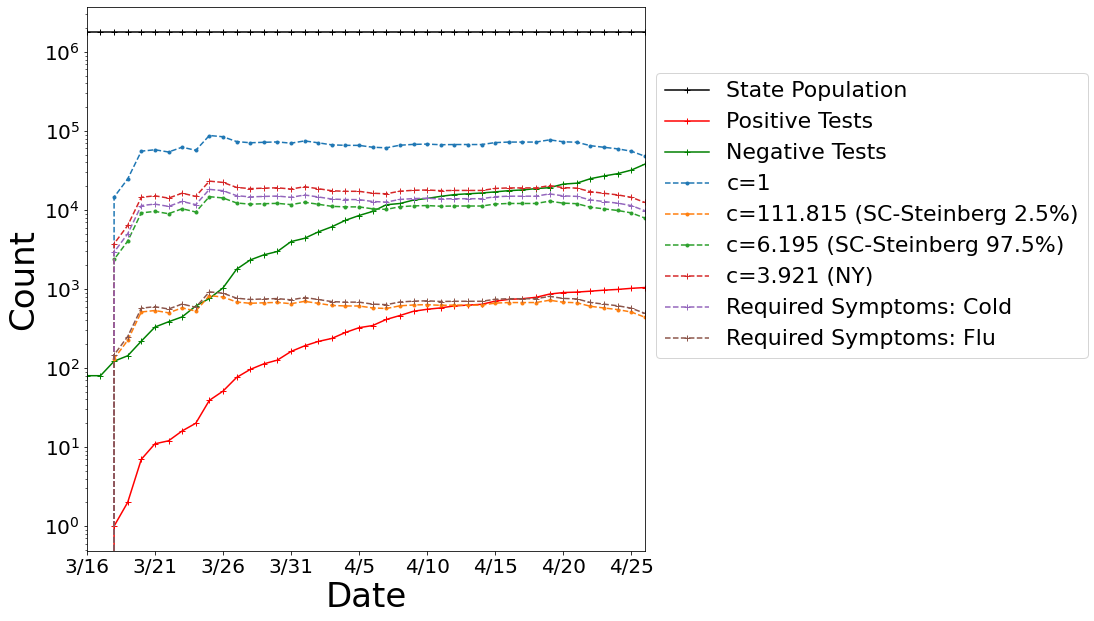

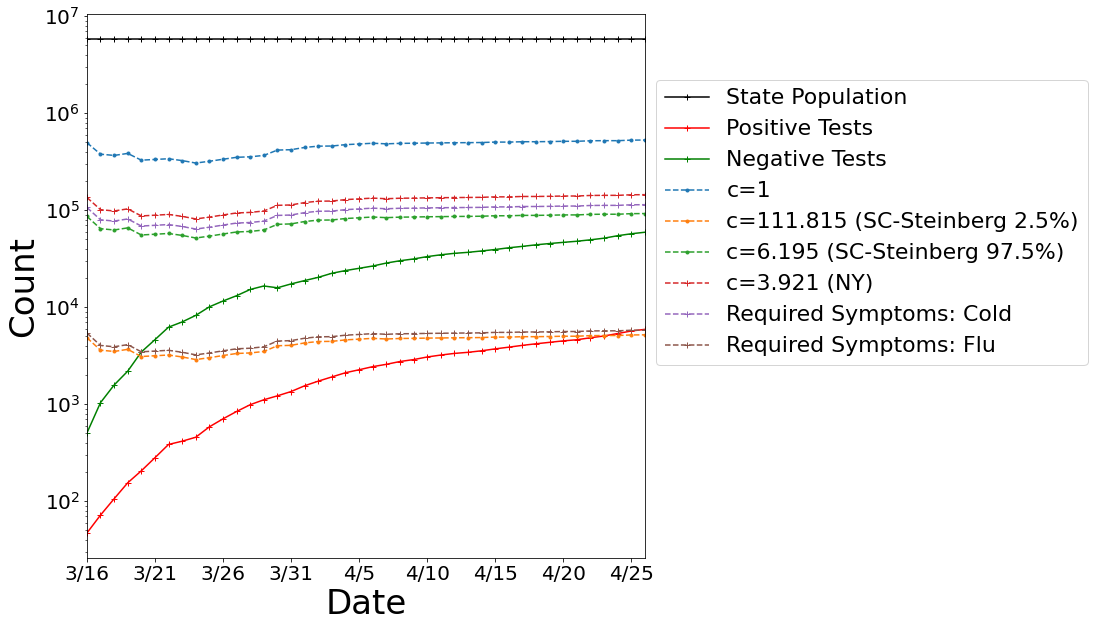

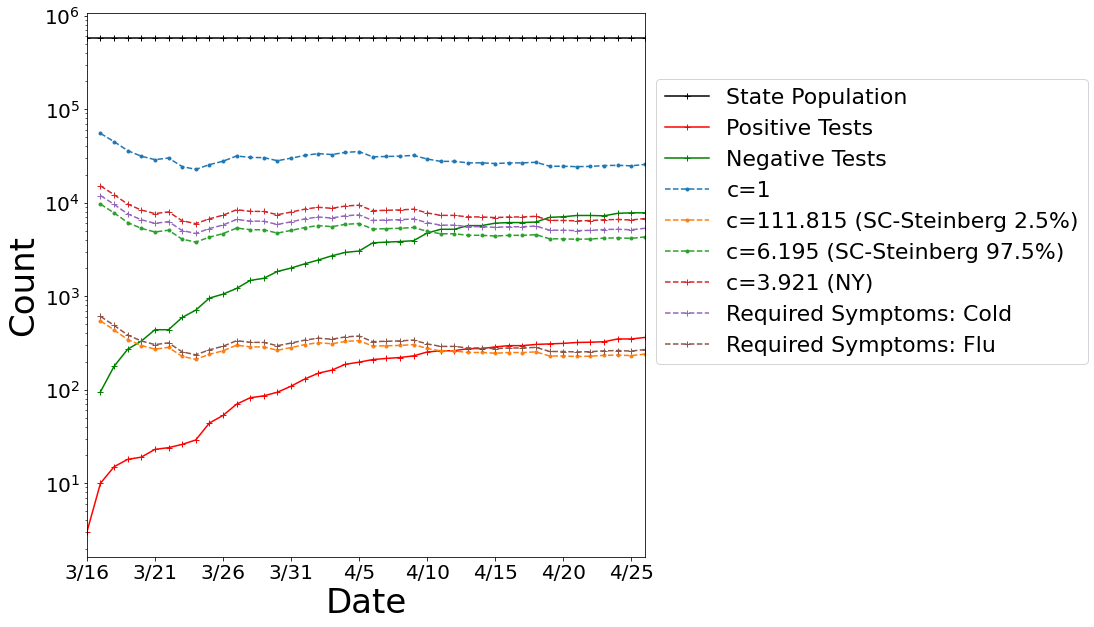

In [9]:
#colors = []
def plot_for_cs(state, cs, save_dir):
    plot_pos_neg_pop(state, dates)
    for i, (c_name, c_key) in enumerate(cs.items()):
        try:
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.semilogy(latent_totals, label='{}'.format(c_name), linestyle='--', marker=markers[i // 3])
    finalize_plot(dates, "Count", "{}/{}.pdf".format(save_dir, state))

prevalence_bad_flu = 0.001
prevalence_flu = 0.005
prevalence_cold = 0.1
symptomatic_covid = 0.5

c_cold = symptomatic_covid / prevalence_cold
c_flu  = symptomatic_covid / prevalence_flu
c_bad_flu = symptomatic_covid / prevalence_bad_flu

for state in state_pops.keys():
    # Plot estimated total infections based on static c
    fig = plt.figure(figsize=(10, 10))
    plot_for_cs(state, {'c=1': 1, 
                        #'c=1e1': 1e1,
                        #'c=1e2': 1e2,
                        "c={:.3f} (SC-Steinberg 2.5%)".format(c_stanford_min): c_stanford_min,
                        #'c={:.2f} (Stanford Mean)'.format(c_stanford_mean): c_stanford_mean,
                        'c={:.3f} (SC-Steinberg 97.5%)'.format(c_stanford_max): c_stanford_max,
                        'c={:.3f} (NY)'.format(c_nyc_mean): c_nyc_mean,
                        #'c={:.2f} (NY Upper)'.format(c_nyc_upper): c_nyc_upper,
                        #'c={:.2f} (FL Mean)'.format(c_flo): c_flo,
                        #'c=Dynamic': lambda j: linear(0, n_dates-1, c_stanford_lower, c_flo, j),
                        'Required Symptoms: Cold': c_cold, 
                        'Required Symptoms: Flu': c_flu,
                        #'Required Symptoms: Bad Flu': c_bad_flu,
                        #'Required Symptoms: Flu->Cold': lambda j: logistic(0, n_dates-1, c_flu, c_cold, j, 10),
                        #'Required Symptoms: Bad Flu->Flu': lambda j: logistic(0, n_dates-1, c_bad_flu, c_flu, j, 10)
                },
               "results/")